<h1>Food Energy Flows Exploratorium</h1>
<p>A project by <a href="http://www.csaladen.es" target="_blank" >Dénes Csala</a> and <a href="http://www.ssgouridis.org" target="_blank" >Sgouris Sgouridis</a> at <a  href="https://www.lancs.ac.uk" target="_blank">Lancaster University</a></p>
<h2><br>Food Energy Flows  Data Plotter Notebook</h2>

<p>This workbook will guide you through the post-processing, and plotting the data generated by the <i>Food Energy Flows Data Parser Notebook</i>. We conduct a thourough data analysis and create visualizations connecting this work with the outputs of the <a href="http://set.csaladen.es" target="_blank">Sustainable Energy Transitions</a> project.
</p>
<p>This is document has been created using  <a target="_blank" href="http://ipython.org/">IPython Notebook</a> in the <a target="_blank" href="https://store.continuum.io/cshop/anaconda/">Anaconda</a> distribution and it can be edited and run in <i>active</i> mode by clicking download in top right corner of this page. The code is partitioned into sections, called <i>cells</i>. When you are using this workbook in <i>active</i> mode, double-click on a cell to edit it and then run using <code>Ctrl + Enter</code>. Hitting <code>Shift + Enter</code> runs the code and steps into the next cell, while <code>Alt + Enter</code> runs the code and adds a new, empty cell. If you are running this notebook on a presonal computer, you will need a machine with at least <i>1GB</i> of memory (<i>2GB</i> recommended) and a processor of <i>1GHz</i>.</p>

In [1]:
import numpy as np, requests, zipfile, StringIO, pandas as pd, json, copy

#suppres warnings
import warnings
warnings.simplefilter(action = "ignore")

Afer importing the necessary libraries, we connect to the <a href="http://faostat.fao.org/Portals/_Faostat/Downloads/zip_files/">*FAOSTAT* database</a> and define indicator paths. Alternatively, the *FAOSTAT* database is mirrored at the project website's <a href="http://food.csaladen.es/db/">data repository</a> (<i>FAOSTAT</i>, has no directory listing access, just on a file-by-file basis). *FAOSTAT* offers the data in the format of zipped *CSV (comma-separated values)* files, and it has a separate file for each of their 17 domains. Should you choose to download the entire database to your local folder, please set the variable <code>localpath</code> to <code>True</code> and indicate this path in the <code>masterpath</code> variable. If you choose to use the online resources directly, please set <code>localpath</code> to <code>False</code> and use the appropiate <code>masterpath</code> (*FAOSTAT* or project website), as indicated below. 

In [8]:
#masterpath = 'http://faostat3.fao.org/faostat-bulkdownloads/'                  #new FAOSTAT
#masterpath = 'http://faostat.fao.org/Portals/_Faostat/Downloads/zip_files/'   #old FAOSTAT
masterpath = 'https://dl.dropboxusercontent.com/u/531697/datarepo/Food-Energy/db/'  #alternative for FAO database
savepath = 'https://dl.dropboxusercontent.com/u/531697/datarepo/Food-Energy/json/'  #alternative for FAO database

localpath=True
networkpath=False #if running on hihg performance remote network PC
networkid=0 #if running on a remote PC, type 0 for HP, 1 for Dell

if localpath:
    #local path for downloaded FAO database, only for developer purposes
    if networkpath:
        #netowkr path for downloaded FAO database, only for developer purposes
        if (networkid==0): nid='Z:' 
        else: nid='W:'
    else: nid='E:/Dropbox (MIT)'
    masterpath = nid+'/Public/Food-Energy/db/' 
    savepath = nid+'/Public/Food-Energy/json/'
    plotpath = nid+'/Public/Food-Energy/plots/'
    
indicators=[] #we store indicator name strings in this string array - do not touch
indicators.append('Emissions_Agriculture_Energy_E_All_Data') #0
indicators.append('Inputs_Fertilizers_E_All_Data') #1
indicators.append('Resources_FertilizersArchive_E_All_Data') #2
indicators.append('Population_E_All_Data') #3
indicators.append('FoodBalanceSheets_E_All_Data') #4
indicators.append('Environment_Energy_E_All_Data') #5
indicators.append('Resources_Land_E_All_Data') #6
indicators.append('Trade_Crops_Livestock_E_All_Data') #7

<p>After defining the indicator names, we define the function <code>get_data(ind,cols,icols)</code> that loads the data from the respective *CSV* from inside the corresponding *ZIP* file into a *pandas* dataframe.  This can take anywhere from a few seconds to several minutes, depending on your computer's performance. If you are running this notebook live and have access to paralell computing capabilites please turn them on at the *Clusters* tab of the main Ipython window. The syntax is slightly different for locally mirorred data and direct online access. By using compound indexing, we only load the relevant portions of the *CSV* files. The indicator oridnal (defined above) is passed with the argument <code>ind</code>, the argument <code>cols</code> defines which columns to load and <code>icols</code> defines which columns to use as indices and their hierarchy. Make sure you run the cells above first, as the <code>get_data()</code> function uses their output. The <code>path</code> variable is an array that containes 3 strings, in the following order: url or directory path, zip file name, csv file name (in case of *FAO*, the two last entries happend to coincide). The <code>elements</code>, <code>items</code> and <code>units</code> arguments are arrays of strings, providing different levels of data filtering, preserving order hierarchy.</p>

In [9]:
def get_data(path,cols=[],icols=[],elements=[],items=[],units=[]):
    if localpath:
        r = path[0]+path[1]+'.zip'                          #define name of zip file to read
        z = zipfile.ZipFile(r)                              #open zip file for access
    else:
        r = requests.get(path[0]+path[1]+'.zip')            #define URL path of zip file to read
        z = zipfile.ZipFile(StringIO.StringIO(r.content))   #stream web content of zip file to read
    if elements:
        if items:
            if units:
                return pd.read_csv(z.open(path[2]+'.csv'),usecols=cols,index_col=icols)\
                         .query('Element=='+repr(elements)+'and Item=='+repr(items)+'and Unit=='+repr(units))\
                         .drop('Unit', axis=1)
            else:
                return pd.read_csv(z.open(path[2]+'.csv'),usecols=cols,index_col=icols)\
                         .query('Element=='+repr(elements)+'and Item=='+repr(items))
        else:
            return pd.read_csv(z.open(path[2]+'.csv'),usecols=cols,index_col=icols)\
                     .query('Element=='+repr(elements))
    elif icols:
        return pd.read_csv(z.open(path[2]+'.csv'),usecols=cols,index_col=icols)
    elif cols:
        return pd.read_csv(z.open(path[2]+'.csv'),usecols=cols)
    else:
        return pd.read_csv(z.open(path[2]+'.csv'))

In [10]:
def new_get_data(path,cols=[],icols=[],elements=[],items=[],units=[],years=[1961,2011]):
    if localpath:
        r = path[0]+path[1]+'.zip'                          #define name of zip file to read
        z = zipfile.ZipFile(r)                              #open zip file for access
    else:
        r = requests.get(path[0]+path[1]+'.zip')            #define URL path of zip file to read
        z = zipfile.ZipFile(StringIO.StringIO(r.content))   #stream web content of zip file to read
    yrrange=['Y'+repr(year) for year in range(years[0],years[1])] #keep only good years, drop fiscal years
    if elements:
        if items:
            if units:
                return pd.read_csv(z.open(path[2]+'.csv'),usecols=cols+yrrange,index_col=icols)\
                         .query('Element=='+repr(elements)+'and Item=='+repr(items)+'and Unit=='+repr(units))\
                         .drop('Unit', axis=1)
            else:
                return pd.read_csv(z.open(path[2]+'.csv'),usecols=cols+yrrange,index_col=icols)\
                         .query('Element=='+repr(elements)+'and Item=='+repr(items))
        else:
            return pd.read_csv(z.open(path[2]+'.csv'),usecols=cols+yrrange,index_col=icols)\
                     .query('Element=='+repr(elements))
    elif icols:
        return pd.read_csv(z.open(path[2]+'.csv'),usecols=cols+yrrange,index_col=icols)
    elif cols:
        return pd.read_csv(z.open(path[2]+'.csv'),usecols=cols+yrrange)
    else:
        return pd.read_csv(z.open(path[2]+'.csv'))

In [11]:
elements=['Food supply (kcal/capita/day)','Food supply quantity (kg/capita/yr)']\
        +['Feed','Food','Processing','Other uses','Seed','Waste',\
          'Import Quantity','Export Quantity','Stock Variation']\
        +['Production']

itemfilter='(((2511<=ItemCode)&(ItemCode<=2782))\
                              |(ItemCode==2805)\
                              |(ItemCode==2899)\
                              |(ItemCode==2912)\
                              |(ItemCode==2948)\
                              |(ItemCode==2901)\
                              |(ItemCode==2960)\
                              |(ItemCode==2961))'
        
balance = new_get_data([masterpath,indicators[4],indicators[4]],\
                      ['Country','Item','Element','Item Code'],[0,3,2],elements,[],[],[1961,2012])
#need to save ItemCodes for categorization
#note that for balance, the categories that are of interest to us are stored in the Element column
#extra processing for new FAO data tables
balance.columns=['ItemCode']+range(1961,2012)
balance=balance.query(itemfilter).set_index("ItemCode", append=True)
balance=pd.DataFrame(balance.stack()).reset_index(level='ItemCode')
balance.columns=['ItemCode','Value']
balance.index = balance.index.swaplevel(1, 3)
balance.index.names=([u'Country', 'Year', u'Item', u'Element'])
balance.xs(['Brazil',1961,'Maize and products'], level=[0,1,2])#.head()
#data availability is 1961-2011

,ItemCode,Value
Element,,
Production,2514,9036.00
Import Quantity,2514,6.00
Stock Variation,2514,0.00
Export Quantity,2514,4.00
Feed,2514,5961.00
Seed,2514,184.00
Waste,2514,904.00
Processing,2514,4.00
Food,2514,1985.00


In [12]:
elements=['Area']
items=['Agricultural area']
yld = get_data([masterpath,indicators[6],indicators[6]],\
                        ['Country','Item','Element','Year','Value'],[0,3,2,1],elements,items)
#note that for area, the categories that are of interest to us are stored in the Item column
yld.xs(['Brazil',1961], level=[0,1]).head()
#data availability is 1961-2011

,,Value
Element,Item,
Area,Agricultural area,150531


In [14]:
#WDI database access, needed for fossil-to-electrcity part
#wdipath = 'http://databank.worldbank.org/data/download/'
wdipath = 'https://dl.dropboxusercontent.com/u/531697/datarepo/Food-Energy/db/' #alternative mirror for WDI database
if localpath:
    #local path for downloaded FAO database, only for developer purposes
    wdipath = masterpath
    
wdindicators=[] #we store indicator name strings in this string array - do not touch
wdindicators.append('WDI_Data') #0
wdindicators.append('WDI_Description') #1
wdindicators.append('WDI_Country') #2
wdindicators.append('WDI_Series') #3
wdindicators.append('WDI_CS_Notes') #4
wdindicators.append('WDI_ST_Notes') #5
wdindicators.append('WDI_Footnotes') #6

elsources1=['Electricity production from coal sources (% of total)',\
'Electricity production from natural gas sources (% of total)',\
'Electricity production from oil sources (% of total)']
elsources2=['Electricity production from nuclear sources (% of total)',\
'Electricity production from hydroelectric sources (% of total)',\
'Electricity production from renewable sources, excluding hydroelectric (% of total)']
electricity=get_data([wdipath,'WDI_csv',wdindicators[0]])
electricity.columns=['Country','Code','Indicator','ICode']+[1960+i for i in range(len(electricity.columns)-4)] #range(54) #old WDI
electricity=electricity.drop('Code', axis=1).drop('ICode', axis=1)\
                       .query('Indicator=='+repr(elsources1+elsources2)).set_index(['Country','Indicator'],drop=True)
#data availability is 1960-2014/5/6/...

Helper function to create dictionary arrays. descirption here

In [15]:
def country_name_converter(country):
    #convert country names between FAO and WDI databases
    if "\xf4" in country: return country[0:country.find("\xf4")]+"o"+country[country.find("\xf4")+1:len(country)]
    elif "of America" in country: return country[0:country.find("of America")-1]
    elif country == 'China, Hong Kong SAR': return 'Hong Kong SAR, China'
    elif country == 'China, Macao SAR': return 'Macao SAR, China'
    elif country == 'Democratic Republic of the Congo': return 'Congo, Dem. Rep.'
    elif country == 'Egypt': return 'Egypt, Arab Rep.'
    elif country == 'Faroe Islands': return 'Faeroe Islands'
    elif country == 'Iran': return 'Iran, Islamic Rep.'
    elif country == 'Iran (Islamic Republic of)': return 'Iran, Islamic Rep.'
    elif country == 'Kyrgyzstan': return 'Kyrgyz Republic'
    elif country == "Lao People's Democratic Republic": return 'Lao PDR'
    elif country == 'Occupied Palestinian Territory': return 'West Bank and Gaza'
    elif country == 'Republic of Korea': return 'Korea, Rep.'
    elif country == 'Republic of Moldova': return 'Moldova'
    elif country == 'Slovakia': return 'Slovak Republic'
    elif country == 'The former Yugoslav Republic of Macedonia': return 'Macedonia, FYR'
    elif country == 'Yemen': return 'Yemen, Rep.'
    elif country == 'Viet Nam': return 'Vietnam'
    elif country == 'Venezuela': return 'Venezuela, RB'
    elif country == 'Venezuela (Bolivarian Republic of)': return 'Venezuela, RB'    
    elif country == 'United Republic of Tanzania': return 'Tanzania'
    
    #special countries, existing in the past, electricity generation values estimated from contemporary countries
    elif country == 'Serbia and Montenegro': return 'Serbia'
    elif country == 'Saint Vincent and the Grenadines': return 'St. Vincent and the Grenadines'
    elif country == 'China, mainland': return 'China'
    elif country == 'Ethiopia PDR': return 'Ethiopia'
    elif country == 'USSR': return 'Russian Federation'
    elif country == 'Yugoslav SFR': return 'Serbia'
    elif country == 'Bahamas': return 'Bahamas, The'
    elif country == 'Saint Lucia': return 'St. Lucia'
    elif country == 'Belgium-Luxembourg': return 'Belgium'
    elif country == 'Gambia': return 'Gambia, The'
    elif country == "Democratic People's Republic of Korea": return 'Korea, Dem. Rep.'
    elif country == 'Saint Kitts and Nevis': return 'St. Kitts and Nevis'
    elif country == 'Congo': return 'Congo, Rep.'
    elif country == 'Czechoslovakia': return 'Czech Republic'
    
    #aggregate regions 
    elif country == 'Central America + (Total)': return 'Mexico and Central America'
    elif country == 'Eastern Asia + (Total)': return 'East Asia & Pacific (all income levels)'
    elif country == 'Least Developed Countries + (Total)': return 'Least developed countries: UN classification'
    elif country == 'Low Income Food Deficit Countries + (Total)': return 'Low income'
    elif country == 'Northern Africa + (Total)': return 'Middle East & North Africa (all income levels)'
    elif country == 'Northern America + (Total)': return 'North America'
    elif country == 'South America + (Total)': return 'Latin America & Caribbean (all income levels)'
    elif country == 'Southern Africa + (Total)': return 'Sub-Saharan Africa (all income levels)'
    elif country == 'Southern Asia + (Total)': return 'South Asia'
    elif country == 'Caribbean + (Total)': return 'Caribbean small states'
    elif country == 'Small Island Developing States + (Total)': return 'Pacific island small states'
    elif "+" in country: return country[0:country.find("+")-1]
    elif "(" in country: return country[0:country.find("(")-1]
    
    else: return country

In [16]:
def country_name_converter2(country):
    #convert country names between databases
    if country=='Serbia and Montenegro': return 'Serbia'
    elif country=='Russian Federation': return 'Russia'
    elif country=='United States Virgin Islands': return 'Virgin Islands'
    elif country=='Iran (Islamic Republic of)': return 'Iran'
    elif country=='Viet Nam': return 'Vietnam'
    elif country=='China, mainland': return 'China'
    elif country=='United States of America': return 'United States'
    elif country=='Falkland Islands (Malvinas)': return 'Falkland Islands (Islas Malvinas)'
    elif country=='Ethiopia PDR': return 'Ethiopia'
    elif country=='Bolivia (Plurinational State of)': return 'Bolivia'
    elif country=='USSR': return 'Russia'
    elif country=='World + (Total)': return 'Pacific Ocean'
    elif country=='Yugoslav SFR': return 'Serbia'
    elif country=='Republic of Moldova': return 'Moldova'
    elif country=='Bahamas': return 'Bahamas, The'
    elif country=='Pacific Islands Trust Territory': return 'Pacific Ocean'
    elif country=="Lao People's Democratic Republic": return 'Laos'
    elif country=='Belgium-Luxembourg': return 'Belgium'
    elif country=='China, Hong Kong SAR': return 'Hong Kong'
    elif country=='Gambia': return 'Gambia, The'
    elif country=='China, Macao SAR': return 'Macau'
    elif country=='United Republic of Tanzania': return 'Tanzania'
    elif country=='Wallis and Futuna Islands': return 'Wallis and Futuna'
    elif country=='Venezuela (Bolivarian Republic of)': return 'Venezuela'
    elif country=='Occupied Palestinian Territory': return 'West Bank'
    elif country=='Syrian Arab Republic': return 'Syria'
    elif country=='Republic of Korea': return 'Korea, South'
    elif country=="Democratic People's Republic of Korea": return 'Korea, North'
    elif country=='Brunei Darussalam': return 'Brunei'
    elif country=='Democratic Republic of the Congo': return 'Congo, Democratic Republic of the'
    elif country=='Micronesia (Federated States of)': return 'Micronesia, Federated States of'
    elif country=='Holy See': return 'Holy See (Vatican City)'
    elif country=='The former Yugoslav Republic of Macedonia': return 'Macedonia'
    elif country=='R\xe9union': return 'Reunion'
    elif country=='China, Taiwan Province of': return 'Taiwan'
    elif country=="C\xf4te d'Ivoire": return "Cote d'Ivoire"
    elif country=='Myanmar': return 'Burma'
    elif country=='Sudan (former)': return 'Sudan'
    elif country=='Congo': return 'Congo, Republic of the'
    elif country=='Netherlands Antilles': return 'Aruba'
    elif country=='Czechoslovakia': return 'Czech Republic'
    else: return country

In [17]:
def country_name_converter3(country):
    #convert country names for Sankey app
    
    #aggregate regions 
    if "+" in country: return "~ "+country[0:country.find("+")-1]
    elif "(" in country: return country[0:country.find("(")-1]
    
    #countries
    elif "\xf4" in country: return country[0:country.find("\xf4")]+"o"+country[country.find("\xf4")+1:len(country)]
    elif "of America" in country: return country[0:country.find("of America")-1]
    elif country == 'China, Hong Kong SAR': return 'Hong Kong SAR, China'
    elif country == 'China, Macao SAR': return 'Macao SAR, China'
    elif country == 'China, Taiwan province of': return 'Taiwan'
    elif country == 'Democratic Republic of the Congo': return 'Congo, DRC'
    elif country == "Lao People's Democratic Republic": return 'Lao PDR'
    elif country == 'Republic of Korea': return 'Korea, South'
    elif country == 'Republic of Moldova': return 'Moldova'
    elif country == 'The former Yugoslav Republic of Macedonia': return 'Macedonia, FYR'
    elif country == 'Viet Nam': return 'Vietnam'
    elif country == 'United Republic of Tanzania': return 'Tanzania'
    elif country == "Democratic People's Republic of Korea": return 'Korea, North'
    elif country == "Syrian Arab Republic": return 'Syria'
    
    #special countries, existing in the past, electricity generation values estimated from contemporary countries
    elif country == 'Serbia and Montenegro': return '{former} Serbia and Montenegro'
    elif country == 'China, mainland': return '{former} China, mainland'
    elif country == 'Ethiopia PDR': return '{former} Ethiopia, PDR'
    elif country == 'USSR': return '{former} USSR'
    elif country == 'Yugoslav SFR': return '{former} Yugoslav SFR'
    elif country == 'Belgium-Luxembourg': return '{former} Belgium-Luxembourg'
    elif country == 'Czechoslovakia': return '{former} Czechoslovakia'
    
    else: return country

In [18]:
def country_name_converter4(country):
    #convert country names for World Map app
    
    #from FAO
    if country == 'China, Hong Kong SAR': return 'Hong Kong'
    #elif country == 'China, mainland': return 'China'
    elif country == 'China, Macao SAR': return 'Macao, China'
    elif country == "Lao People's Democratic Republic": return "Lao People's Dem. Rep."
    elif country == 'Sao Tome and Principe': return 'S\xe3o Tom\xe9 and Principe'
    elif country == 'Cabo Verde': return 'Cape Verde'
    elif country == 'Iran (Islamic Republic of)': return 'Iran'
    elif country == 'Viet Nam': return 'Vietnam'
    elif country == 'United States of America': return 'United States'
    elif country == 'Bolivia (Plurinational State of)': return 'Bolivia'
    elif country == 'Central African Republic': return 'Cent African Rep'
    elif country == 'Occupied Palestinian Territory': return 'Palestinian Territories'
    elif country == 'Republic of Moldova': return 'Rep. of Moldova'
    elif country == 'Libya': return 'Libyan Arab Jamahiriya'
    elif country == 'United Republic of Tanzania': return 'Tanzania'
    elif country == 'Venezuela (Bolivarian Republic of)': return 'Venezuela'
    elif country == 'Republic of Korea': return 'Rep. of Korea'
    elif country == "Democratic People's Republic of Korea": return "People's Republic of Korea"
    elif country == 'The former Yugoslav Republic of Macedonia': return 'FYR of Macedonia'
    elif country == 'China, Taiwan Province of': return 'Taiwan'
    elif country == 'Sudan (former)': return 'Sudan'
    elif country == 'Myanmar': return 'Myanmar (Burma)'
    
    #from WDI
    elif country == 'Bahamas, The' :return 'Bahamas'
    elif country == 'Congo, Dem. Rep.':return 'Dem. Rep. of Congo'
    elif country == 'Congo, Rep.':return 'Congo'
    elif country == "Cote d'Ivoire": return  "C\xf4te d'Ivoire"
    elif country == 'Egypt, Arab Rep.':return 'Egypt'
    elif country == 'Gambia, The':return 'Gambia'
    elif country == 'Hong Kong SAR, China': return 'Hong Kong'
    elif country == 'Iran, Islamic Rep.': return 'Iran'
    elif country == 'Korea, Dem. Rep.' : return "People's Republic of Korea"
    elif country == 'Korea, Rep.': return 'Rep. of Korea'
    elif country == 'Kyrgyz Republic':return 'Kyrgyzstan'
    elif country == 'Lao PDR': return "Lao People's Dem. Rep."
    elif country == 'Macao SAR, China': return 'Macao, China'
    elif country == 'Macedonia, FYR': return 'FYR of Macedonia'
    elif country == 'Micronesia, Fed. Sts.' :return 'Micronesia (Federated States of)'
    elif country == 'Moldova':return 'Rep. of Moldova'
    elif country == 'Slovak Republic':return 'Slovakia'
    elif country == 'St. Kitts and Nevis':return 'Saint Kitts and Nevis'
    elif country == 'St. Lucia':return 'Saint Lucia'
    elif country == 'St. Vincent and the Grenadines':return 'Saint Vincent and the Grenadines'
    elif country == 'Venezuela, RB': return 'Venezuela'
    elif country == 'Virgin Islands (U.S.)':return 'US Virgin Islands'
    elif country == 'West Bank and Gaza':return 'Palestinian Territories'
    elif country == 'Yemen, Rep.':return 'Yemen'
    
    else: return country

Interpolator function

In [19]:
def interpolate(d,years,gfit=2,depth=1,polyorder=1,override=False):
    #depth * length of interpolation substrings will be taken to the left and right
    #for example for {1971:5,1972:6,1973:7,1974:5} interpolating it over 1969-1990
    #for the section 1960-1970 (2 elements) the values from 1972,1973,1974 (3 elements) will be taken with depth 1.5
    #for the section 1974-1990 (15 elements) all values  (4 elements) will be taken to extrapolate
    if (gfit>2): 
        print 'interpolate takes only 1 (polynomial) or 2 (exponential) as 3rd argument [default=2]'
        return
    mydict={}
    missing_points=[[]]
    for year in years:
        if year not in d.keys():
            missing_points[-1].append(year)
        else:
            missing_points.append([])
    for m in missing_points:
        if m:
            fit=gfit
            if ((m[-1]<sorted(d.keys())[0])|(m[0]>sorted(d.keys())[-1])): #check if it is ends of the interval, then extrapolate mean only
                if not override: fit=0
            
            if fit==0: #take average
                y = {k: d[k] for k in set(d.keys()).intersection(range(max(min(years),min(m)-int(3)),min(max(years),max(m)+int(3))+1))}
                for i in range(len(m)):
                    mydict[m[i]]=np.mean(y.values())
            elif fit==1:
                #intersector
                y = {k: d[k] for k in set(d.keys()).intersection(range(max(min(years),min(m)-int(depth*len(m))),min(max(years),max(m)+int(depth*len(m)))+1))}
                #print y
                w = np.polyfit(y.keys(),y.values(),polyorder) # obtaining regression parameters
                if (polyorder==1):
                    intersector=w[0]*np.array(m)+w[1]
                else:
                    intersector=w[0]*np.array(m)*np.array(m)+w[1]*np.array(m)+w[2]
                for i in range(len(m)):
                    mydict[m[i]]=max(0,intersector[i])
            else:
                #intersector
                y = {k: d[k] for k in set(d.keys()).intersection(range(max(min(years),min(m)-int(depth*len(m))),min(max(years),max(m)+int(depth*len(m)))+1))}
                #print y
                w = np.polyfit(y.keys(),np.log(y.values()),1) # obtaining log regression parameters (exp fitting)
                intersector=np.exp(w[1])*np.exp(w[0]*np.array(m))
                for i in range(len(m)):
                    mydict[m[i]]=max(0,intersector[i])
    
    #return interpolated points
    return mydict

<h2>3. Visualization</h2>
<h3>3.1. Sankey Diagram</h3>
<p>After the *JSON* files have been created, they are used as input for generating the *Sankey* diagrams. Using the *HTML* library, we can display a snippet of the final website below. The driving logic of the *HTML* is as follows: the main *Javascript* function <code>change</code> loads the corresponding *JSON* based on the *country* and *year* selections into the <code>sankey</code> variable. All data is loaded asynchronously, on-demand. A modified version on the the *Sankey* module of *D3.js* creates the nodes and links from the data and displays the diagram as *Scalable Vector Graphics (SVG)* elements onto the browser's canvas, defined in the <code>svg</code> variable. Upon a change in the data source, the size parameters of the SVG elements are modified and elements are added or removed, as necessary. Upon hover over a node or a link, the <code>updatepie</code> function displays the corresponding the pie chart, using information from the *supply* field of the *JSON* data. Please view the *HTML* source of the <a href="http://food.csaladen.es">project website</a> for a thorough understanding of the canvas painting process. The diagram usage instructions are briefly presented here:</p>

<ul><li>Data<ul>	<li>Select the country, year and the desired detail level from the menu on the right.</li>
<li>You can choose from 3 different datasets (vertical): <ul><li>Gross energy [TWh]</li><li> Food energy [TWh]</li><li> Food weight [ktonnes].</li></ul></li>
<li>and 4 detail levels (horizontal): <ul><li>Food supergroups</li><li>*FAO* food groups</li><li>*FAO* crop groups</li><li>Test</li></ul></li>
</ul></li><li>Layout<ul>
<li>The recommended minimum resolution is 800x600</li>
<li>Scrolling over the diagram will advance time</li>
<li>Node and flow heights will be defined by the main unit of the dataset.</li>
<li>Drag nodes around to adjust the layout of the diagram. </li>
<li>Enable/disable horizontal/vertical node movement from the menu on the right.</li>
<li>Double click a node to hide/show all of its incoming flows.</li>
<li>Hover over a flow to display:<ul><li> its value and breakdown in [TWh] and [ktonnes]</li><li>its caloric value in [kcal/100g]</li></ul></li>
<li>Hover over a node to display its value in the main unit of the dataset.</li>
</ul><li>Pie chart<ul>
<li>Upon hover over a node or a flow, a pie chart will show in the bottom right corner. </li>
<li>When over a flow, its breakdown will be displayed, with the value at the center.</li>
<li>When over a node, the incoming and outgoing flow breakdowns will be displayed. </li>
<li>You can enable or disable items on the pie chart by clicking on the legend entries.</li>
<li>Hover over a pie chart slice to display its value.</li>
<li>Pie chart units always correspond to the main unit of the dataset.</li>
</ul></li><li>Help<ul>
<li>Use the menu next to the title to view the world map and the detailed help.</li></ul>
</ul>

EROEI Scatterplot

In [20]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib as mpl
mpl.rc('font', family='Trebuchet MS')

In [21]:
countries_base=sorted(list({i for i in balance.index.get_level_values('Country').unique() if "+" not in i})+['World + (Total)'])
regions={'Small Island Developing States + (Total)','Caribbean + (Total)','Eastern Asia + (Total)','European Union + (Total)','Least Developed Countries + (Total)',\
 'Low Income Food Deficit Countries + (Total)','Northern Africa + (Total)','Northern America + (Total)',\
 'South America + (Total)','Southern Africa + (Total)','Southern Asia + (Total)','World + (Total)'}
years=range(1961,2012)
countries=list(countries_base)+list(regions)

# Energy share

In [ ]:
#process k1, only needs to be run if data changed, otherwise only run next cell, loading data
k1={}
for i in countries:
    for year in years:
        try:
            if localpath: ero=json.loads(file(savepath+country_name_converter3(i)+repr(year)+'k1.json','r').read())
            else: ero=json.loads(requests.get(savepath+country_name_converter3(i)+repr(year)+'k1.json').content)
            if i not in k1: k1[i]={}
            k1[i][year]=ero
        except:pass
file(masterpath.replace('db','db2')+'k1.json','w').write(json.dumps(k1,encoding='latin1'))

In [22]:
#load k1, if previously saved
k1=json.loads(file(masterpath.replace('db','db2')+'k1.json','r').read(),encoding='latin1')

In [23]:
#food system data
fooden_bycountry={}
fooden_bytime={}
for i in countries:
    fooden_bycountry[i]=[[],[]]
    for year in years:
        try:
            try: ero=k1[i][year]
            except: ero=k1[i][repr(year)]
            val=sum([v['value'] for v in ero['links'] if v['source']==0])
            fooden_bycountry[i][0].append(year)
            fooden_bycountry[i][1].append([ero])
            if year not in fooden_bytime: fooden_bytime[year]={}
            fooden_bytime[year].update({i:val})
        except: pass

In [ ]:
#process k2, only needs to be run if data changed, otherwise only run next cell, loading data
k2={}
for i in countries:
    for year in years:
        try:
            if localpath: ero=json.loads(file(savepath+country_name_converter3(i)+repr(year)+'k2.json','r').read())
            else: ero=json.loads(requests.get(savepath+country_name_converter3(i)+repr(year)+'k2.json').content)
            if i not in k2: k2[i]={}
            k2[i][year]=ero
        except:pass
file(masterpath.replace('db','db2')+'k2.json','w').write(json.dumps(k2,encoding='latin1'))

In [24]:
#load k2, if previously saved
k2=json.loads(file(masterpath.replace('db','db2')+'k2.json','r').read(),encoding='latin1')

In [25]:
#agri-system data
fooden_bycountry2={}
fooden_bytime2={}
for i in countries:
    fooden_bycountry2[i]=[[],[]]
    for year in years:
        try:
            try: ero=k2[i][year]
            except: ero=k2[i][repr(year)]
            val=sum([v['value'] for v in ero['links'] if v['source']==0])
            fooden_bycountry2[i][0].append(year)
            fooden_bycountry2[i][1].append([ero])
            if year not in fooden_bytime2: fooden_bytime2[year]={}
            fooden_bytime2[year].update({i:val})
        except: pass

In [23]:
#process m, only needs to be run if data changed, otherwise only run next cell, loading data
m={}
for i in countries:
    try:
        if localpath: ero=json.loads(file(savepath+country_name_converter3(i)+'m.json','r').read())
        else: ero=json.loads(requests.get(savepath+country_name_converter3(i)+'m.json').content)
        m[i]=ero
    except:pass
file(masterpath.replace('db','db2')+'m.json','w').write(json.dumps(m,encoding='latin1'))

In [26]:
#load m, if previously saved
m=json.loads(file(masterpath.replace('db','db2')+'m.json','r').read(),encoding='latin1')

In [27]:
#food eroei data
eroei_bycountry={}
eroei_bytime={}
eroei_raw_bycountry={}
eroei_raw_bytime={}
aec_bycountry={}
aec_bytime={}
missing_bycountry={}
quality_threshold=100
for i in countries:
    try:
        mis=m[i]
        missing_bycountry[i]=len(mis['missing'])
    except: pass
for i in missing_bycountry.keys():
    if missing_bycountry[i]<quality_threshold:
        try:
            eroei_bycountry[i]=[[],[]]
            eroei_raw_bycountry[i]=[[],[]]
            aec_bycountry[i]=[[],[]]
            ero=m[i]
            for j in sorted(ero["eroei"][1].keys()):
                eroei_bycountry[i][0].append(int(j))
                eroei_raw_bycountry[i][0].append(int(j))
                aec_bycountry[i][0].append(int(j))
                eroei_bycountry[i][1].append(ero["eroei"][1][j])
                eroei_raw_bycountry[i][1].append(ero["eroei_raw"][1][j])
                aec_bycountry[i][1].append(ero["aec"][1][j])
                if int(j) not in eroei_bytime: eroei_bytime[int(j)]={}
                eroei_bytime[int(j)].update({i:ero["eroei"][1][j]})
                if int(j) not in eroei_raw_bytime: eroei_raw_bytime[int(j)]={}
                eroei_raw_bytime[int(j)].update({i:ero["eroei_raw"][1][j]})
                if int(j) not in aec_bytime: aec_bytime[int(j)]={}
                aec_bytime[int(j)].update({i:ero["aec"][1][j]})
        except: pass

In [28]:
#agri eroei data
eroei_bycountry2={}
eroei_bytime2={}
eroei_raw_bycountry2={}
eroei_raw_bytime2={}
aec_bycountry2={}
aec_bytime2={}
missing_bycountry2={}
for i in countries:
    try:
        mis=m[i]
        missing_bycountry2[i]=len(mis['missing'])
    except: pass
for i in missing_bycountry2.keys():
    if missing_bycountry2[i]<quality_threshold:
        try:
            eroei_bycountry2[i]=[[],[]]
            eroei_raw_bycountry2[i]=[[],[]]
            aec_bycountry2[i]=[[],[]]
            ero=m[i]
            for j in sorted(ero["eroei"][2].keys()):
                eroei_bycountry2[i][0].append(int(j))
                eroei_raw_bycountry2[i][0].append(int(j))
                aec_bycountry2[i][0].append(int(j))
                eroei_bycountry2[i][1].append(ero["eroei"][2][j])
                eroei_raw_bycountry2[i][1].append(ero["eroei_raw"][2][j])
                aec_bycountry2[i][1].append(ero["aec"][2][j])
                if int(j) not in eroei_bytime2: eroei_bytime2[int(j)]={}
                eroei_bytime2[int(j)].update({i:ero["eroei"][2][j]})
                if int(j) not in eroei_raw_bytime2: eroei_raw_bytime2[int(j)]={}
                eroei_raw_bytime2[int(j)].update({i:ero["eroei_raw"][2][j]})
                if int(j) not in aec_bytime2: aec_bytime2[int(j)]={}
                aec_bytime2[int(j)].update({i:ero["aec"][2][j]})
        except: pass

In [29]:
#agricultural area
yld_bycountry={}
for country in countries:
    try:
        yld_bycountry[country]=[[],[]]
        yld_bycountry[country][0]=[i for i in yld.xs([country,'Area','Agricultural area'], level=[0,2,3]).index]
        yld_bycountry[country][1]=[i[0] for i in yld.xs([country,'Area','Agricultural area'], level=[0,2,3]).values]
    except: pass

In [43]:
#process d01, only needs to be run if data changed, otherwise only run next cell, loading data
d01={}
for i in countries:
    for year in years:
        try:
            if localpath: ero=json.loads(file(savepath+country_name_converter3(i)+repr(year)+'01.json','r').read())
            else: ero=json.loads(requests.get(savepath+country_name_converter3(i)+repr(year)+'01.json').content)
            if i not in d01: d01[i]={}
            d01[i][year]=ero
        except:pass
file(masterpath.replace('db','db2')+'d01.json','w').write(json.dumps(d01,encoding='latin1'))

In [30]:
#load d01, if previously saved
d01=json.loads(file(masterpath.replace('db','db2')+'d01.json','r').read(),encoding='latin1')

In [31]:
#food breakdown
foodbr_bycountry={}
for i in countries:
    foodbr_bycountry[i]=[[],[]]
    for year in years:
        try:
            try: ero=d01[i][year]
            except: ero=d01[i][repr(year)]
            foodbr_bycountry[i][0].append(year)
            foodbr_bycountry[i][1].append([ero])
        except: pass

In [44]:
#process d02, only needs to be run if data changed, otherwise only run next cell, loading data
d02={}
for i in countries:
    for year in years:
        try:
            if localpath: ero=json.loads(file(savepath+country_name_converter3(i)+repr(year)+'02.json','r').read())
            else: ero=json.loads(requests.get(savepath+country_name_converter3(i)+repr(year)+'02.json').content)
            if i not in d02: d02[i]={}
            d02[i][year]=ero
        except:pass
file(masterpath.replace('db','db2')+'d02.json','w').write(json.dumps(d02,encoding='latin1'))

In [32]:
#load d02, if previously saved
d02=json.loads(file(masterpath.replace('db','db2')+'d02.json','r').read(),encoding='latin1')

In [33]:
#agri breakdown
foodbr_bycountry2={}
for i in countries:
    foodbr_bycountry2[i]=[[],[]]
    for year in years:
        try:
            try: ero=d02[i][year]
            except: ero=d02[i][repr(year)]
            foodbr_bycountry2[i][0].append(year)
            foodbr_bycountry2[i][1].append([ero])
        except: pass

In [34]:
def bgcolor(themeid):
    if themeid==0: return "#ffffff"
    if themeid==1: return "#111111"
def textcolor(themeid):
    if themeid==0: return "#000000"
    if themeid==1: return "#aaaa88"
def bordercolor(themeid):
    if themeid==0: return "#eeeeee"
    if themeid==1: return "#222222"
def initplotcolors(themeid):
    mpl.rcParams['text.color'] = textcolor(themeid)
    mpl.rcParams['xtick.color'] = textcolor(themeid)
    mpl.rcParams['ytick.color'] = textcolor(themeid)
    mpl.rcParams['axes.labelcolor'] = textcolor(themeid)
    mpl.rcParams['axes.edgecolor'] = textcolor(themeid)
    mpl.rcParams['axes.facecolor'] = bordercolor(themeid)
    mpl.rcParams['patch.edgecolor'] = "#222222" #bordercolor(themeid)

In [35]:
def anistack(frame, themeid):
    
    global ax
    
    if frame==0:
        country='World + (Total)'
    else:
        country=countries[frame-1]
        
    for i in ax:
        for j in i:
            j.cla()
        
    #if True:
    try:
        #--------------------
        x=fooden_bycountry[country][0]
        #--------------------
        #food outputs
        y=[0 for i in range(len(x))]
        labels=[]
        fooden_bytype={u'Food':[],u'Biofuels & Other':[],u'Export':[],u'Stock Deposit':[]}
        w=[{fooden_bycountry[country][1][j][0]['nodes'][fooden_bycountry[country][1][j][0]['links'][i]['target']]['name']:\
                  fooden_bycountry[country][1][j][0]['links'][i]['value'] for i in range(len(fooden_bycountry[country][1][j][0]['links'])) if \
                 fooden_bycountry[country][1][j][0]['links'][i]['source']==0} for j in range(len(fooden_bycountry[country][0]))]
        for j in w:
            for k in fooden_bytype:
                if k not in j: fooden_bytype[k].append(0)
                else: fooden_bytype[k].append(j[k])
        
        #attach stock at the beginning
        label=u'Stock Deposit'
        y=np.vstack((fooden_bytype[label],y)) 
        labels.append(label)
        
        for label in fooden_bytype:
            if label not in {u'Stock Deposit'}:
                try: 
                    y=np.vstack((fooden_bytype[label],y)) 
                    labels.append(label)
                except: pass
                
        sp=ax[0][1].stackplot(x,y,alpha=0.9, colors=[u'#e7ba52',u'#aec7e8',u'#b5cf6b',u'#c7c7c7'])
        proxy = [mpl.patches.Rectangle((0,0), 0,0, facecolor=sp[pol].get_facecolor()[0]) for pol in range(len(sp)-1)][::-1]
        legend=ax[0][1].legend(proxy, (labels),loc=2,framealpha=0.5,fontsize=10)
        frame = legend.get_frame()
        frame.set_facecolor(bgcolor(themeid))
        frame.set_edgecolor(textcolor(themeid))
        
        #--------------------
        #food output breakdown
        y=[0 for i in range(len(x))]
        labels=[]
        source_bytype={u'Cereals':[],u'Fruits, Roots & Vegetables':[],u'Sugar Crops':[],u'Oilcrops':[],\
                      u'Animal Products':[],u'Aquatic Products':[],u'Sugar':[],u'Other Processed':[],u'Vegetable Oils':[],\
                      u'Animal & Aquatic Products':[],u'Oil Products':[],u'Sugar Products':[]}
        for i in range(len(foodbr_bycountry[country][0])):
            sourcelist={}
            targetlist={}
            for s in source_bytype:
                source_bytype[s].append(0)
            for j in range(len(foodbr_bycountry[country][1][i][0]['nodes'])):
                if foodbr_bycountry[country][1][i][0]['nodes'][j]['name'] in fooden_bytype:
                    targetlist[j]=foodbr_bycountry[country][1][i][0]['nodes'][j]['name']
                if foodbr_bycountry[country][1][i][0]['nodes'][j]['name'] in source_bytype:
                    sourcelist[j]=foodbr_bycountry[country][1][i][0]['nodes'][j]['name']
            for j in foodbr_bycountry[country][1][i][0]['links']:
                if ((j['source'] in sourcelist) and (j['target'] in targetlist)):
                    source_bytype[sourcelist[j['source']]][i]+=j['value']
                    if sourcelist[j['source']] in [u'Animal Products',u'Aquatic Products',u'Other Processed']:
                        source_bytype[u'Animal & Aquatic Products'][i]+=j['value']
                    if sourcelist[j['source']] in [u'Oilcrops',u'Vegetable Oils']:
                        source_bytype[u'Oil Products'][i]+=j['value']
                    if sourcelist[j['source']] in [u'Sugar Crops',u'Sugar']:
                        source_bytype[u'Sugar Products'][i]+=j['value']
        
        for label in [u'Cereals',u'Fruits, Roots & Vegetables',u'Sugar Products',u'Oil Products',u'Animal & Aquatic Products'][::-1]:
            try: 
                y=np.vstack((source_bytype[label],y)) 
                labels.append(label)
            except: pass
        
        sp=ax[0][2].stackplot(x,y/y.sum(axis=0).astype(float) * 100 ,alpha=0.9, colors=[u'#e7ba52',u'#98df8a',u'#ffbb78',u'#ff9896',u'#17becf'])
        proxy = [mpl.patches.Rectangle((0,0), 0,0, facecolor=sp[pol].get_facecolor()[0]) for pol in range(len(sp)-1)][::-1]
        legend=ax[0][2].legend(proxy, (labels),loc=2,framealpha=0.5,fontsize=10)
        frame = legend.get_frame()
        frame.set_facecolor(bgcolor(themeid))
        frame.set_edgecolor(textcolor(themeid))
        ax[0][2].set_ylim(0,100)
        #legendtexts = legend.get_texts()
        #for t in legendtexts:
        #    t.set_color(bordercolor(themeid))
        
        #--------------------
        #food inputs
        y=[0 for i in range(len(x))]
        labels=[]
        fooden_bytype={u'Fossil Fuels':[],u'Labor':[],u'Renewables & Nuclear':[],u'Stock Draw':[]}
        w=[{fooden_bycountry[country][1][j][0]['nodes'][fooden_bycountry[country][1][j][0]['links'][i]['source']]['name']:\
                  fooden_bycountry[country][1][j][0]['links'][i]['value'] for i in range(len(fooden_bycountry[country][1][j][0]['links'])) if \
                 fooden_bycountry[country][1][j][0]['links'][i]['target']==0} for j in range(len(fooden_bycountry[country][0]))]
        for j in w:
            for k in fooden_bytype:
                if k not in j: fooden_bytype[k].append(0)
                else: fooden_bytype[k].append(j[k])
        
        #attach stock at the beginning
        label=u'Stock Draw'
        y=np.vstack((fooden_bytype[label],y)) 
        labels.append(label)
            
        for label in fooden_bytype:
            if label not in {u'Stock Draw'}:
                try: 
                    y=np.vstack((fooden_bytype[label],y)) 
                    labels.append(label)
                except: pass
        
        sp=ax[0][0].stackplot(x,y,alpha=0.9,colors=[u'#c7c7c7',u'#c49c94',u'#2ca02c',u'#c7c7c7'])
        proxy = [mpl.patches.Rectangle((0,0), 0,0, facecolor=sp[pol].get_facecolor()[0]) for pol in range(len(sp)-1)][::-1]
        legend=ax[0][0].legend(proxy, (labels),loc=2,framealpha=0.5,fontsize=10)
        frame = legend.get_frame()
        frame.set_facecolor(bgcolor(themeid))
        frame.set_edgecolor(textcolor(themeid))

        #--------------------
        x=fooden_bycountry2[country][0]
        #--------------------
        #agri outputs
        y=[0 for i in range(len(x))]
        labels=[]
        fooden_bytype={u'Food':[]}
        w=[{fooden_bycountry2[country][1][j][0]['nodes'][fooden_bycountry2[country][1][j][0]['links'][i]['target']]['name']:\
                  fooden_bycountry2[country][1][j][0]['links'][i]['value'] for i in range(len(fooden_bycountry2[country][1][j][0]['links'])) if \
                 fooden_bycountry2[country][1][j][0]['links'][i]['source']==0} for j in range(len(fooden_bycountry2[country][0]))]
        for j in w:
            for k in fooden_bytype:
                if k not in j: fooden_bytype[k].append(0)
                else: fooden_bytype[k].append(j[k])
        
        #attach stock at the beginning
        label=u'Food'
        y=np.vstack((fooden_bytype[label],y)) 
        labels.append('Production')
        
        sp=ax[1][1].stackplot(x,y,alpha=0.9, colors=[u'#b5cf6b'])
        proxy = [mpl.patches.Rectangle((0,0), 0,0, facecolor=sp[pol].get_facecolor()[0]) for pol in range(len(sp)-1)][::-1]
        legend=ax[1][1].legend(proxy, (labels),loc=2,framealpha=0.5,fontsize=10)
        frame = legend.get_frame()
        frame.set_facecolor(bgcolor(themeid))
        frame.set_edgecolor(textcolor(themeid))
        
        #--------------------
        #agri output breakdown
        y=[0 for i in range(len(x))]
        labels=[]
        fooden_bytype={u'Production':[]}
        source_bytype={u'Cereals':[],u'Fruits, Roots & Vegetables':[],u'Sugar Crops':[],u'Oilcrops':[]}
        for i in range(len(foodbr_bycountry2[country][0])):
            sourcelist={}
            targetlist={}
            for s in source_bytype:
                source_bytype[s].append(0)
            for j in range(len(foodbr_bycountry2[country][1][i][0]['nodes'])):
                if foodbr_bycountry2[country][1][i][0]['nodes'][j]['name'] in fooden_bytype:
                    targetlist[j]=foodbr_bycountry2[country][1][i][0]['nodes'][j]['name']
                if foodbr_bycountry2[country][1][i][0]['nodes'][j]['name'] in source_bytype:
                    sourcelist[j]=foodbr_bycountry2[country][1][i][0]['nodes'][j]['name']
            for j in foodbr_bycountry2[country][1][i][0]['links']:
                if ((j['source'] in sourcelist) and (j['target'] in targetlist)):
                    source_bytype[sourcelist[j['source']]][i]+=j['value']
        
        for label in [u'Cereals',u'Fruits, Roots & Vegetables',u'Sugar Crops',u'Oilcrops'][::-1]:
            try: 
                y=np.vstack((source_bytype[label],y)) 
                labels.append(label)
            except: pass
        
        sp=ax[1][2].stackplot(x,y/y.sum(axis=0).astype(float) * 100 ,alpha=0.9, colors=[u'#e7ba52',u'#98df8a',u'#ffbb78',u'#ff9896'])
        proxy = [mpl.patches.Rectangle((0,0), 0,0, facecolor=sp[pol].get_facecolor()[0]) for pol in range(len(sp)-1)][::-1]
        legend=ax[1][2].legend(proxy, (labels),loc=2,framealpha=0.5,fontsize=10)
        frame = legend.get_frame()
        frame.set_facecolor(bgcolor(themeid))
        frame.set_edgecolor(textcolor(themeid))
        ax[1][2].set_ylim(0,100)
        #legendtexts = legend.get_texts()
        #for t in legendtexts:
        #    t.set_color(bordercolor(themeid))
        
        #--------------------
        #agri inputs
        y=[0 for i in range(len(x))]
        labels=[]
        fooden_bytype={u'Fossil Fuels':[],u'Labor':[],u'Renewables & Nuclear':[]}
        w=[{fooden_bycountry2[country][1][j][0]['nodes'][fooden_bycountry2[country][1][j][0]['links'][i]['source']]['name']:\
                  fooden_bycountry2[country][1][j][0]['links'][i]['value'] for i in range(len(fooden_bycountry2[country][1][j][0]['links'])) if \
                 fooden_bycountry2[country][1][j][0]['links'][i]['target']==0} for j in range(len(fooden_bycountry2[country][0]))]
        for j in w:
            for k in fooden_bytype:
                if k not in j: fooden_bytype[k].append(0)
                else: fooden_bytype[k].append(j[k])
            
        for label in fooden_bytype:
            if label not in {u'Stock Draw'}:
                try: 
                    y=np.vstack((fooden_bytype[label],y)) 
                    labels.append(label)
                except: pass
        
        sp=ax[1][0].stackplot(x,y,alpha=0.9,colors=[u'#c7c7c7',u'#c49c94',u'#2ca02c'])
        proxy = [mpl.patches.Rectangle((0,0), 0,0, facecolor=sp[pol].get_facecolor()[0]) for pol in range(len(sp)-1)][::-1]
        legend=ax[1][0].legend(proxy, (labels),loc=2,framealpha=0.5,fontsize=10)
        frame = legend.get_frame()
        frame.set_facecolor(bgcolor(themeid))
        frame.set_edgecolor(textcolor(themeid))
    
        #--------------------
        #food eroei
        ax[2][0].plot(eroei_raw_bycountry[country][0],eroei_raw_bycountry[country][1],linewidth=4,color="#006CD9",label="EROEI$_{raw}$")
        ax[2][0].plot(eroei_bycountry[country][0],eroei_bycountry[country][1],linewidth=4,color="#ff6600",label="EROEI$_{adj}$")
        ax[2][0].plot(aec_bycountry[country][0],np.array(aec_bycountry[country][1])/aec_bycountry[country][1][0],linewidth=4,color="#22aa22",label="NAEC")
        ax[2][0].plot(x,[1 for i in range(len(x))],linestyle="-",linewidth=2,color=bgcolor(themeid),zorder=0)
        ax[2][0].legend(loc=2,framealpha=0.5,fontsize=10)
        ax[2][0].set_ylim(0,10)
        
        #--------------------
        #agri eroei
        ax[2][1].plot(eroei_raw_bycountry2[country][0],eroei_raw_bycountry2[country][1],linewidth=4,color="#006CD9",label="EROEI$_{raw}$")
        ax[2][1].plot(eroei_bycountry2[country][0],eroei_bycountry2[country][1],linewidth=4,color="#ff6600",label="EROEI$_{adj}$")
        ax[2][1].plot(aec_bycountry2[country][0],np.array(aec_bycountry2[country][1])/aec_bycountry2[country][1][0],linewidth=4,color="#22aa22",label="NAEC")
        ax[2][1].plot(x,[1 for i in range(len(x))],linestyle="-",linewidth=2,color=bgcolor(themeid),zorder=0)
        ax[2][1].legend(loc=2,framealpha=0.5,fontsize=10)
        ax[2][1].set_ylim(0,10)
        
        #--------------------
        #agri area
        sp=ax[2][2].stackplot(yld_bycountry[country][0],np.array(yld_bycountry[country][1])/1000,alpha=0.9, colors=[u'#b5cf6b'])
        proxy = [mpl.patches.Rectangle((0,0), 0,0, facecolor=pol.get_facecolor()[0]) for pol in sp]
        legend=ax[2][2].legend(proxy, (['Agricultural area']),loc=2,framealpha=0.5,fontsize=10)
        frame = legend.get_frame()
        frame.set_facecolor(bgcolor(themeid))
        frame.set_edgecolor(textcolor(themeid))
        
        #--------------------
        #plot formatting
        for i in range(3):
            for j in range(3):
                ax[i][j].set_xlim([1960,2011])
                ax[i][j].grid(color=bgcolor(themeid), linestyle='solid')
            ax[0][i].set_xticklabels([])
            ax[1][i].set_xticklabels([])
        
        ax[2][0].set_xlabel('Year',labelpad=5,size=11)
        ax[2][1].set_xlabel('Year',labelpad=5,size=11)
        ax[2][2].set_xlabel('Year',labelpad=5,size=11)
            
        ax[0][0].text(-0.15,0.5,'Energy [TWh]',size=11,\
                     verticalalignment='center',horizontalalignment='right',rotation=90,transform=ax[0][0].transAxes)
        ax[1][0].text(-0.15,0.5,'Energy [TWh]',size=11,\
                     verticalalignment='center',horizontalalignment='right',rotation=90,transform=ax[1][0].transAxes)
        ax[2][0].text(-0.15,0.5,'EROEI',size=11,\
                     verticalalignment='center',horizontalalignment='right',rotation=90,transform=ax[2][0].transAxes)
        
        ax[0][0].text(0.5,1.05,'Food system inputs [TWh]',size=11,\
                     horizontalalignment='center',transform=ax[0][0].transAxes)
        ax[0][1].text(0.5,1.05,'Food system outputs [TWh]',size=11,\
                     horizontalalignment='center',transform=ax[0][1].transAxes)
        ax[1][0].text(0.5,1.05,'Agri-system inputs [TWh]',size=11,\
                     horizontalalignment='center',transform=ax[1][0].transAxes)
        ax[1][1].text(0.5,1.05,'Agri-system outputs [TWh]',size=11,\
                     horizontalalignment='center',transform=ax[1][1].transAxes)
        ax[0][2].text(0.5,1.05,'Food system output breakdown [%]',size=11,\
                     horizontalalignment='center',transform=ax[0][2].transAxes)
        ax[1][2].text(0.5,1.05,'Agri-system output breakdown [%]',size=11,\
                     horizontalalignment='center',transform=ax[1][2].transAxes)
        ax[2][0].text(0.5,1.05,'Evolution of Food system EROEI',size=11,\
                     horizontalalignment='center',transform=ax[2][0].transAxes)
        ax[2][1].text(0.5,1.05,'Evolution of Agri-system EROEI',size=11,\
                     horizontalalignment='center',transform=ax[2][1].transAxes)
        ax[2][2].text(0.5,1.05,'Agricultural area [MHa]',size=11,\
                     horizontalalignment='center',transform=ax[2][2].transAxes)
        
        ax[2][1].text(0.5,-0.45,country_name_converter3(country),size=18,\
                     horizontalalignment='center',transform=ax[2][1].transAxes)
        ax[0][1].text(0.5,1.25,'Energy input-output balance of the agriculture and food systems',size=18,\
                     horizontalalignment='center',transform=ax[0][1].transAxes)
        
        fig.subplots_adjust(left=0.27,wspace=0.2)
        
        fig.savefig(plotpath+country_name_converter3(country)+'_energy'+repr(themeid)+'.png',bbox_inches = 'tight', pad_inches = 0.1, dpi=150,
                   facecolor=bgcolor(themeid),edgecolor=bordercolor(themeid))
        
    except: pass

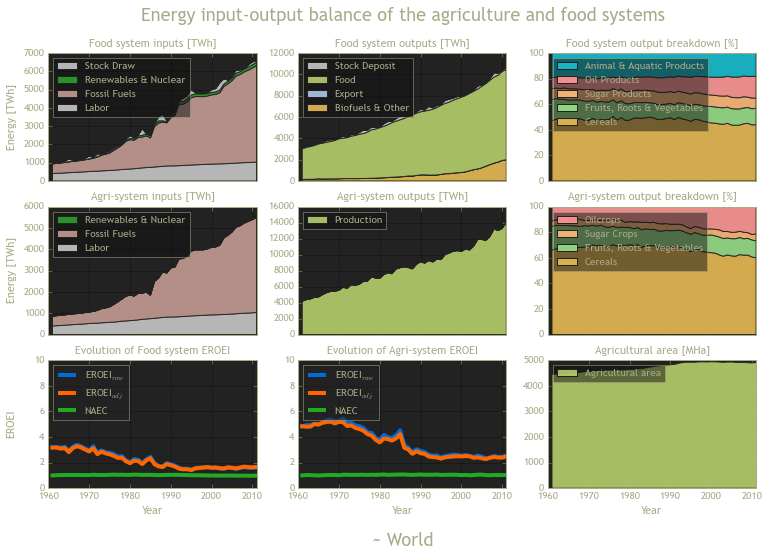

In [31]:
#no JSAnimation version

themeid=1 #define theme id [currently 0 light 1 dark]
initplotcolors(themeid)
fig, ax = plt.subplots(3,3,subplot_kw=dict(axisbelow=True),figsize=(13+2.6,6.5+1.3))
anistack(0,themeid) #plot world with theme themeid

In [ ]:
#process all countries for all themes - might take a while
for country in range(len(countries)):
    for themeid in [0,1]:
        try:
            initplotcolors(themeid)
            fig, ax = plt.subplots(3,3,subplot_kw=dict(axisbelow=True),figsize=(13+2.6,6.5+1.3))
            anistack(country,themeid)
            plt.close();
        except: pass

EROEI plots

In [36]:
def eroeiplotter(themeid):
    
    global ax
    
    ax[0].grid(color=bgcolor(themeid), linestyle='solid')
    ax[1].grid(color=bgcolor(themeid), linestyle='solid')

    #food system- output energy weighted average
    x=eroei_bytime.keys()
    y=np.array([np.average({k:v for (k,v) in eroei_bytime[i].iteritems() \
                            if k in set(eroei_bytime[i].keys()).intersection(fooden_bytime[i].keys())}.values(),
                weights={k:v for (k,v) in fooden_bytime[i].iteritems() \
                        if k in set(eroei_bytime[i].keys()).intersection(fooden_bytime[i].keys())}.values()) \
                for i in eroei_bytime])
    s=np.array([np.std(eroei_bytime[i].values()) for i in eroei_bytime])
    line1 = ax[0].plot(x,y,linewidth=4,label="# World (calculated)",color="#22aa22")
    line2 = ax[0].plot(x,eroei_bycountry['World + (Total)'][1],linewidth=4,color="#ff6600",label="~ World (FAO aggregate)")
    ax[0].plot(x,[1 for i in range(len(x))],linestyle="-",linewidth=2,color=bgcolor(themeid),zorder=0)
    ax[0].plot(0,0,linewidth=8,c=u'#22aa22',label='$\sigma$',alpha=0.3)
    fill=ax[0].fill_between(x, y+s, y-s, facecolor=u'#22aa22', alpha=0.3)

    #agri-system - output energy weighted average
    y=np.array([np.average({k:v for (k,v) in eroei_bytime2[i].iteritems() \
                            if k in set(eroei_bytime2[i].keys()).intersection(fooden_bytime2[i].keys())}.values(),
                weights={k:v for (k,v) in fooden_bytime2[i].iteritems() \
                        if k in set(eroei_bytime2[i].keys()).intersection(fooden_bytime2[i].keys())}.values()) \
                for i in eroei_bytime2])
    s=np.array([np.std(eroei_bytime2[i].values()) for i in eroei_bytime2])
    line1 = ax[1].plot(x,y,linewidth=4,label="# World (calculated)",color="#22aa22")
    line2 = ax[1].plot(x,eroei_bycountry2['World + (Total)'][1],linewidth=4,color="#ff6600",label="~ World (FAO aggregate)")
    ax[1].plot(x,[1 for i in range(len(x))],linestyle="-",linewidth=2,color=bgcolor(themeid),zorder=0)
    ax[1].plot(0,0,linewidth=8,c=u'#22aa22',label='$\sigma$',alpha=0.3)
    fill=ax[1].fill_between(x, y+s, y-s, facecolor=u'#22aa22', alpha=0.3)

    for i in range(2):
        ax[i].set_xlim([1960,2011])
        ax[i].set_ylim([0,10])
        ax[i].set_xlabel('Year',labelpad=5, size=12)
        ax[i].legend(framealpha=0.5,loc=2,fontsize=10)

    ax[0].set_ylabel('Food system EROEI',labelpad=10, size=12)
    ax[1].set_ylabel('Agri-system EROEI',labelpad=10, size=12)

    plt.suptitle("Energy return on energy invested (EROEI)", size=16, y=1.02)
    plt.savefig(plotpath+'EROEI'+repr(themeid)+'.png',bbox_inches = 'tight', pad_inches = 0.1, dpi=150,
                       facecolor=bgcolor(themeid),edgecolor=bordercolor(themeid))

In [ ]:
#define list flattener #http://stackoverflow.com/questions/2158395/flatten-an-irregular-list-of-lists-in-python
flatten = lambda *n: (e for a in n
    for e in (flatten(*a) if isinstance(a, (tuple, list)) else (a,)))

def eroeiplotter2(themeid):
    
    global ax
    label=['Food ','Agri-']
    rlabel=['(adjusted for crop energy content)','(unadjusted)']
    
    for k in range(2):
        for i in range(2):
            #system output energy weighted average
            #animvalues(i,k) #eroeiid (0-food, 1-agri), rawid
            y=np.array([np.mean(np.array([R[year][1][j]*R[year][2][j]/np.mean(R[year][2]) for j in range(len(R[year][1]))])) for year in years])
            s=np.array([np.std(np.array([R[year][1][j]*R[year][2][j]/np.mean(R[year][2]) for j in range(len(R[year][1]))])) for year in years])
            ax[k][i*2].grid(color=bgcolor(themeid), linestyle='solid')
            ax[k][i*2].plot(years,y,linewidth=4,label="# World (calculated)",color="#22aa22")
            ax[k][i*2].plot(years,[WLD[year][1] for year in years],linewidth=4,color="#ff6600",label="~ World (FAO aggregate)")
            ax[k][i*2].plot(years,[1 for j in range(len(years))],linestyle="-",linewidth=2,color=bgcolor(themeid),zorder=0)
            ax[k][i*2].plot(0,0,linewidth=8,c=u'#22aa22',label='$\sigma$',alpha=0.3)
            fill=ax[k][i*2].fill_between(years, y+s, y-s, facecolor=u'#22aa22', alpha=0.3)
            ax[k][i*2+1].hist(list(flatten([[R[year][1][j]*R[year][2][j] for j in range(len(R[year][1]))] for year in years])),\
                       bins=np.arange(20)/2.0,orientation="horizontal",color="#22aa22",alpha=0.3)
            ax[k][i*2].set_xlim([1960,2011])
            ax[k][i*2].set_ylim([0,10])
            ax[k][i*2].legend(framealpha=0.5,loc=2,fontsize=10)
            #ax[k][i*2].set_ylabel(label[i]+'system EROEI\n '+rlabel[k],labelpad=10, size=12)
            ax[k][i*2+1].set_yticklabels([])
            ax[k][i*2+1].set_xticks([])
            if (i==1):
                ax[k][i*2+1].set_yticklabels([])
                ax[k][i*2].set_yticklabels([])
            if (k==0):
                ax[k][i*2].set_xticklabels([])
            else:
                ax[k][i*2].set_xlabel('Year',labelpad=5, size=12)

    #ax[0][3].text("Evolution of global energy return on energy invested (EROEI)\nof food and agriculture systems weighted by system energy output")
    
    plt.savefig(plotpath+'EROEI_hist'+repr(themeid)+'.png',bbox_inches = 'tight', pad_inches = 0.1, dpi=150,
                       facecolor=bgcolor(themeid),edgecolor=bordercolor(themeid))

In [ ]:
initplotcolors(themeid)
#fig, ax = plt.subplots(1,2,subplot_kw=dict(axisbelow=True),figsize=(11,4))
#eroeiplotter(themeid)
import matplotlib.gridspec as gridspec
fig = plt.figure(figsize=(16,7))
gs = gridspec.GridSpec(2, 5,width_ratios=[20,6,0.3,20,6,20,6,0.3,20,6])
gs.update(left=0.05, right=0.98, wspace=0.05, hspace=0.05)
ax=[]
for i in range(2):
    ax.append([])
    for j in range(5):
        if (j!=2):
            ax[i].append(plt.subplot(gs[i*5+j]))
            
eroeiplotter2(themeid)

<h3>3.2. World Map & Plotting tools</h3>
<p>After the *JSON* files have been created, they are used as input for generating the *Sankey* diagrams. Using the *HTML* library, we can display

data preparation

In [106]:
#food weight
wrowi_bycountry={}
wrowi_raw_bycountry={}
wrowi_aec_bycountry={}
wrowi_bytime={}
wrowi_raw_bytime={}
wrowi_aec_bytime={}
for i in missing_bycountry.keys():
    if missing_bycountry[i]<quality_threshold:
        try:
            wrowi_bycountry[i]=[[],[]]
            ero=m[i]["eroei"][3]
            for j in sorted(ero.keys()):
                wrowi_bycountry[i][0].append(int(j))
                wrowi_bycountry[i][1].append(ero[j])
                if int(j) not in wrowi_bytime: wrowi_bytime[int(j)]={}
                wrowi_bytime[int(j)].update({i:ero[j]})
        except: pass
        try:
            wrowi_raw_bycountry[i]=[[],[]]
            ero=m[i]["eroei_raw"][3]
            for j in sorted(ero.keys()):
                wrowi_raw_bycountry[i][0].append(int(j))
                wrowi_raw_bycountry[i][1].append(ero[j])
                if int(j) not in wrowi_raw_bytime: wrowi_raw_bytime[int(j)]={}
                wrowi_raw_bytime[int(j)].update({i:ero[j]})
        except: pass
        try:
            wrowi_aec_bycountry[i]=[[],[]]
            ero=m[i]["aec"][3]
            for j in sorted(ero.keys()):
                wrowi_aec_bycountry[i][0].append(int(j))
                wrowi_aec_bycountry[i][1].append(ero[j])
                if int(j) not in wrowi_aec_bytime: wrowi_aec_bytime[int(j)]={}
                wrowi_aec_bytime[int(j)].update({i:ero[j]})
        except: pass

gdp=get_data([wdipath,'WDI_csv',wdindicators[0]])
gdp.columns=['Country','Code','Indicator','ICode']+[1960+i for i in range(len(gdp.columns)-4)] #old 54
gdp=gdp.drop('Code', axis=1).drop('ICode', axis=1)\
                       .query("Indicator== 'GDP per capita (constant 2005 US$)'").drop('Indicator', axis=1)\
                       .set_index(['Country'],drop=True)

#extrapolate Russian GDP (for USSR times)
d2={years[i]:gdp.loc['Russian Federation'].values[i+1] for i in range(len(years)) if ~np.isnan(gdp.loc['Russian Federation'].values[i+1])}
d2.update(interpolate(d2,years))
for year in years:
    gdp.loc['Russian Federation',year]=d2[year]

#load country codes for data.csv and plot annotations  
cc=pd.read_csv(masterpath.replace('db','map/0')+'cc.csv',';')

In [107]:
#calculate country geo centroids
centroids=pd.read_csv(masterpath+'centroids.csv',sep='\t')
country_lat={}
for country in countries:
    try: 
        mystring=centroids.xs(country_name_converter2(country)).index[0]
        if mystring[0]==' ': 
            mystring=mystring[1:len(mystring)]
        country_lat[country]=int(mystring[0:mystring.find(' ')])
        mystring=mystring[(mystring.find(' ')+1):]
        country_lat[country]+=int(mystring[0:mystring.find(' ')])/60.0
        if (mystring[(mystring.find(' ')+1):]=='S'):
            country_lat[country]=country_lat[country]*(-1)
    except: pass

illustrative plots

In [108]:
from operator import itemgetter
p={}
g=[]
R={}
WLD={}

def animvalues(eroeiid,rawid):
    
    global p,g,R,WLD
    
    p={}
    g=[]
    R={}
    WLD={}
    for year in range(1961,2012):
        r=[[],[],[],[],[]]
        wld=[[],[]]
        if (rawid==0):
            if (eroeiid==0):
                for i in eroei_bycountry.keys():
                    if i not in {'China, mainland'}:
                        if i in country_lat:
                            try:
                                if logmode==2:
                                    x=np.log10(gdp.loc[country_name_converter(i),year])
                                    y=np.log10(eroei_bytime[year][i])
                                elif logmode==1:
                                    x=np.log10(gdp.loc[country_name_converter(i),year])
                                    y=eroei_bytime[year][i]
                                else:
                                    x=gdp.loc[country_name_converter(i),year]
                                    y=eroei_bytime[year][i]
                                s=fooden_bytime[year][i]
                                if ~((np.isnan(x))|(np.isnan(y))):
                                    if i not in {'World + (Total)'}:
                                        r[0].append(x)
                                        r[1].append(y)
                                        r[2].append(s)
                                        r[3].append(i)
                                        r[4].append(country_lat[i])
                                    else:
                                        wld[0]=x
                                        wld[1]=y
                            except:pass

                g.append(gdp.loc['World',year])
                try:
                    x=r[0]
                    y=r[1]
                    w = np.linalg.lstsq(np.array([ np.array(x), np.ones(len(x))]).T,y)[0] # obtaining regression parameters
                    p[year]=w[0]
                    R[year]=r
                    WLD[year]=[wld[0],np.average(r[1],weights=r[2])]
                except:pass
            else:
                for i in eroei_bycountry2.keys():
                    if i not in {'China, mainland'}:
                        if i in country_lat:
                            try:
                                if logmode==2:
                                    x=np.log10(gdp.loc[country_name_converter(i),year])
                                    y=np.log10(eroei_bytime2[year][i])
                                elif logmode==1:
                                    x=np.log10(gdp.loc[country_name_converter(i),year])
                                    y=eroei_bytime2[year][i]
                                else:
                                    x=gdp.loc[country_name_converter(i),year]
                                    y=eroei_bytime2[year][i]
                                s=fooden_bytime2[year][i]
                                if ~((np.isnan(x))|(np.isnan(y))):
                                    if i not in {'World + (Total)'}:
                                        r[0].append(x)
                                        r[1].append(y)
                                        r[2].append(s)
                                        r[3].append(i)
                                        r[4].append(country_lat[i])
                                    else:
                                        wld[0]=x
                                        wld[1]=y
                            except:pass

                g.append(gdp.loc['World',year])
                try:
                    x=r[0]
                    y=r[1]
                    w = np.linalg.lstsq(np.array([ np.array(x), np.ones(len(x))]).T,y)[0] # obtaining regression parameters
                    p[year]=w[0]
                    R[year]=r
                    WLD[year]=[wld[0],np.average(r[1],weights=r[2])]
                except:pass
        else:
            if (eroeiid==0):
                for i in eroei_raw_bycountry.keys():
                    if i not in {'China, mainland'}:
                        if i in country_lat:
                            try:
                                if logmode==2:
                                    x=np.log10(gdp.loc[country_name_converter(i),year])
                                    y=np.log10(eroei_raw_bytime[year][i])
                                elif logmode==1:
                                    x=np.log10(gdp.loc[country_name_converter(i),year])
                                    y=eroei_raw_bytime[year][i]
                                else:
                                    x=gdp.loc[country_name_converter(i),year]
                                    y=eroei_raw_bytime[year][i]
                                s=fooden_bytime[year][i]
                                if ~((np.isnan(x))|(np.isnan(y))):
                                    if i not in {'World + (Total)'}:
                                        r[0].append(x)
                                        r[1].append(y)
                                        r[2].append(s)
                                        r[3].append(i)
                                        r[4].append(country_lat[i])
                                    else:
                                        wld[0]=x
                                        wld[1]=y
                            except:pass

                g.append(gdp.loc['World',year])
                try:
                    x=r[0]
                    y=r[1]
                    w = np.linalg.lstsq(np.array([ np.array(x), np.ones(len(x))]).T,y)[0] # obtaining regression parameters
                    p[year]=w[0]
                    R[year]=r
                    WLD[year]=[wld[0],np.average(r[1],weights=r[2])]
                except:pass
            else:
                for i in eroei_raw_bycountry2.keys():
                    if i not in {'China, mainland'}:
                        if i in country_lat:
                            try:
                                if logmode==2:
                                    x=np.log10(gdp.loc[country_name_converter(i),year])
                                    y=np.log10(eroei_raw_bytime2[year][i])
                                elif logmode==1:
                                    x=np.log10(gdp.loc[country_name_converter(i),year])
                                    y=eroei_raw_bytime2[year][i]
                                else:
                                    x=gdp.loc[country_name_converter(i),year]
                                    y=eroei_raw_bytime2[year][i]
                                s=fooden_bytime2[year][i]
                                if ~((np.isnan(x))|(np.isnan(y))):
                                    if i not in {'World + (Total)'}:
                                        r[0].append(x)
                                        r[1].append(y)
                                        r[2].append(s)
                                        r[3].append(i)
                                        r[4].append(country_lat[i])
                                    else:
                                        wld[0]=x
                                        wld[1]=y
                            except:pass

                g.append(gdp.loc['World',year])
                try:
                    x=r[0]
                    y=r[1]
                    w = np.linalg.lstsq(np.array([ np.array(x), np.ones(len(x))]).T,y)[0] # obtaining regression parameters
                    p[year]=w[0]
                    R[year]=r
                    WLD[year]=[wld[0],np.average(r[1],weights=r[2])]
                except:pass

In [109]:
def animate(frame, themeid, eroeiid, rawid):
    
    global ax,cax
    
    #init axes
    ax.cla()
    cax.cla()
    ax.tick_params(direction='out', pad=5)
    ax.grid(color=bgcolor(themeid), linestyle='solid')
    if (eroeiid==0): title='Food '
    else: title='Agri-'
    if (rawid==0): title2='(unadjusted)'
    else: title2='(adjusted for crop energy content)'
    ax.set_title(title+'system EROEI vs. per capita GDP for all countries',size=17)
    ax.title.set_y(1.03)
    ax.text(0.01,-0.12,'GDP / capita [current US$]',size=13, horizontalalignment='left',transform=ax.transAxes)
    ax.text(0.99,-0.12,'Bubble size: '+title+'system energy output [TWh]',size=13, horizontalalignment='right',transform=ax.transAxes)
    ax.text(-0.05,0.5,'EROEI '+title2,size=13, horizontalalignment='right',verticalalignment='center',rotation=90,transform=ax.transAxes)
    if logmode==2:
        ax.set_xlim(2,5)
        ax.set_ylim(-1,1)
        xlabels=[100,200,300,400,500,600,700,800,900,1000,2000,3000,4000,5000,6000,7000,8000,9000,10000,\
             20000,30000,40000,50000,60000,70000,80000,90000,100000]
        ax.set_xticks(np.log10(xlabels))
        ax.set_xticklabels([100,'','','','','','','','',1000,'','','','','','','','',10000,'','','','','','','','',100000])
        ylabels=[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1,2,3,4,5,6,7,8,9,10]
        ax.set_yticks(np.log10(ylabels))
        ax.set_yticklabels([0.1,0.2,'','',0.5,'','','','',1,2,'','',5,'','','','',10])
    elif logmode==1:
        ax.set_xlim(2,5)
        ax.set_ylim(0,5)
        xlabels=[100,200,300,400,500,600,700,800,900,1000,2000,3000,4000,5000,6000,7000,8000,9000,10000,\
             20000,30000,40000,50000,60000,70000,80000,90000,100000]
        ax.set_xticks(np.log10(xlabels))
        ax.set_xticklabels([100,'','','','','','','','',1000,'','','','','','','','',10000,'','','','','','','','',100000])
    else:
        ax.set_xlim(0,50000)
        ax.set_ylim(0,5)
    ax.xaxis.set_ticks_position('bottom')
    ax.yaxis.set_ticks_position('left')
    
    #world + line at EROEI=1
    ax.plot(WLD[frame+years[0]][0], WLD[frame+years[0]][1],marker='^',lw=4,alpha=0.7,color="yellow",markersize=30)
    if (logmode==2): 
        ax.text(WLD[frame+years[0]][0],WLD[frame+years[0]][1]-0.17,'World',horizontalalignment='center',size=13)
        ax.plot([0,100000],[0, 0],color=bgcolor(themeid),linestyle='-',linewidth=2,alpha=0.8,zorder=0)
    else:
        ax.text(WLD[frame+years[0]][0],WLD[frame+years[0]][1]-0.4,'World',horizontalalignment='center',size=13)
        ax.plot([0,100000],[1, 1],color=bgcolor(themeid),linestyle='-',linewidth=2,alpha=0.8,zorder=0)
    
    #countries
    #sort R list first, based on bubblesizes to arrange them in the z-plane and make sure smaller bubbles are on top
    R[frame+years[0]]=np.array(sorted(np.array(R[frame+years[0]],dtype='object').T.tolist(),\
                                      key=itemgetter(2),reverse=True),dtype='object').T.tolist()
    x = R[frame+years[0]][0]
    y = R[frame+years[0]][1]
    sc=ax.scatter(x, y, np.array(R[frame+years[0]][2])*5,R[frame+years[0]][4],alpha=0.5,\
                  cmap = plt.cm.rainbow,vmin=-45,vmax=60,edgecolors=bgcolor(themeid))
    ax.text(0.98,0.9,frame+years[0],size=30,\
             horizontalalignment='right',transform=ax.transAxes)
    
    for i, txt in enumerate(R[frame+years[0]][2]):
        if R[frame+years[0]][2][i]>50:
            #coose color, make darker or lighter, based on theme
            if (themeid==0): col=np.array(cm.jet((R[frame+years[0]][4][i]+45)/105))*0.6
            else: col=np.array(cm.jet((R[frame+years[0]][4][i]+45)/105))*0.9
            col[3]=1 #set alpha back to 1
            if (R[frame+years[0]][1][i] < ax.get_ylim()[1]): #put text only when fits into plot area
                try: ax.text(R[frame+years[0]][0][i],R[frame+years[0]][1][i]-0.02,\
                        cc[country_name_converter4(R[frame+years[0]][3][i])][0],horizontalalignment='center',\
                        verticalalignment='center',size=7+R[frame+years[0]][2][i]**0.35,color=col)
                except: 
                    #put on USSR when it exists
                    if R[frame+years[0]][3][i]=='USSR':
                        ax.text(R[frame+years[0]][0][i],R[frame+years[0]][1][i]-0.02,\
                            'USSR',horizontalalignment='center',verticalalignment='center',size=7+R[frame+years[0]][2][i]**0.35,color=col)

    #bubblesize
    if logmode==0:
        b_dist=[0.245,0.54,0.745]
        b_y=49800
        b_base=0
    elif logmode==1:
        b_dist=[0.245,0.54,0.745]
        b_y=4.95
        b_base=0
    else:
        b_dist=[0.095,0.215,0.30]
        b_y=4.98
        b_base=1
    ax.scatter([b_y],[b_dist[0]-b_base],[1000],facecolors='none',alpha=0.5,edgecolors=textcolor(themeid))
    ax.scatter([b_y],[b_dist[1]-b_base],[5000],facecolors='none',alpha=0.5,edgecolors=textcolor(themeid))
    ax.scatter([b_y],[b_dist[2]-b_base],[10000],facecolors='none',alpha=0.5,edgecolors=textcolor(themeid))
    ax.text(b_y,2.3*b_dist[0]-b_base,'200',size=10, horizontalalignment='right',verticalalignment='center')
    ax.text(b_y,2.3*b_dist[1]-b_base,'1000',size=10, horizontalalignment='right',verticalalignment='center')
    ax.text(b_y,2.2*b_dist[2]-b_base,'2000',size=10, horizontalalignment='right',verticalalignment='center')
    
    #colorbar
    cbar=fig.colorbar(sc, cax=cax,extend='max')
    cbar.set_label('Geographic latitude [degrees]',size=13)
    cbar.set_alpha(1)
    cbar.draw_all()
    
    #regression - weighted after food energy output
    #resort R list, based on GDP to facilitate regression plot
    R[frame+years[0]]=np.array(sorted(np.array(R[frame+years[0]],dtype='object').T.tolist(),\
                                      key=itemgetter(0)),dtype='object').T.tolist()
    x = R[frame+years[0]][0]
    y = R[frame+years[0]][1]
    g = R[frame+years[0]][2] #weights for y
    
    #comment out below to remove regression lines
    if logmode!=0: #regression does not make sense in pure linear scales plot
        try: # main line
            x0=[0,100000]
            #w = np.polynomial.polynomial.polyfit(x,y,1,w=1+np.log10(g)) #log weight
            w = np.polynomial.polynomial.polyfit(x,y,1,w=g) #linear weight
            #comment out next line to remove regression line
            ax.plot([-3,-2],[0,0],color=textcolor(themeid),linestyle='-',linewidth=2,alpha=0.8,\
                    zorder=0,label='energy output-weighted linear regression')
            ax.plot(x0,w[1]*np.array(x0)+w[0],color=textcolor(themeid),linestyle='--',linewidth=2,alpha=0.8,zorder=0)
        except: pass
        if False: #turn 80|20 regression on|off 
            ax.plot([-3,-2],[0,0],color=bgcolor(themeid),linestyle='-',linewidth=2,alpha=0.8,\
                    zorder=0,label='bottom 80% | top 20% regression')
            try: #0-80
                x1=x[0:int(len(x)*perc)]
                x0=[x1[0],x1[len(x1)-1]]
                y1=y[0:int(len(x)*perc)]
                g1=g[0:int(len(x)*perc)]
                w = np.polynomial.polynomial.polyfit(x1,y1,1,w=g1)
                #comment out next line to remove regression line\n",
                ax.plot(x0,w[1]*np.array(x0)+w[0],color=bgcolor(themeid),linestyle='--',linewidth=2,alpha=0.8,zorder=0)
            except: pass
            try: #80-100
                x2=x[int(len(x)*perc):len(x)]
                x0=[x2[0],x2[len(x2)-1]]
                y2=y[int(len(x)*perc):len(x)]
                g2=g[int(len(x)*perc):len(x)]
                w = np.polynomial.polynomial.polyfit(x2,y2,1,w=g2)
                #comment out next line to remove regression line\n",
                ax.plot(x0,w[1]*np.array(x0)+w[0],color=bgcolor(themeid),linestyle='--',linewidth=2,alpha=0.8,zorder=0)
            except: pass
        ax.legend(loc=3,framealpha=0,fontsize=10)
        
    fig.savefig(plotpath+repr(frame+years[0])+'_log'+repr(logmode)+'_eroei'+repr(rawid)+repr(eroeiid)+repr(themeid)+'.png',bbox_inches = 'tight', \

                pad_inches = 0.1, dpi=150, facecolor=bgcolor(themeid),edgecolor=bordercolor(themeid))

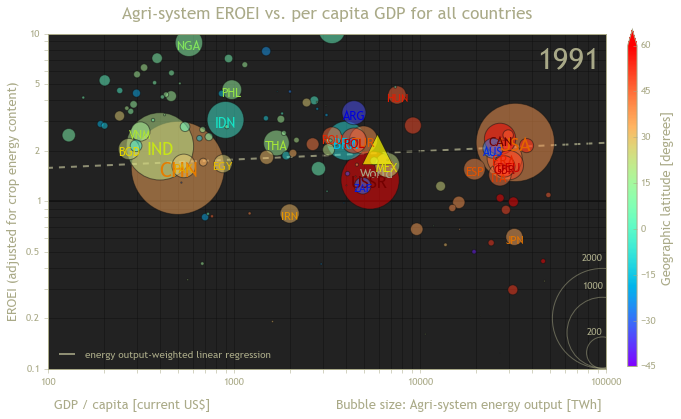

In [78]:
perc=0.8 #income percentage - regression separator

eroeiid=1 #0 - food system, 1 - agri-system
rawid=1 #0 - adjusted eroei, 1 - raw eroei
logmode=2 #linear [0], loglin [1] or loglog [2] plot
animvalues(eroeiid,rawid)

#no JSAnimation version
themeid=1 #define theme id [currently 0 light 1 dark]
initplotcolors(themeid)
fig, ax = plt.subplots(1,1,subplot_kw=dict(axisbelow=True),figsize=(10,6))
cax = fig.add_axes([0.93, 0.13, 0.013, 0.78]) 
animate(30,themeid,eroeiid,rawid) #plot world with theme themeid

In [ ]:
for themeid in [0,1]: #define theme id [currently 0 light 1 dark]
    initplotcolors(themeid)
    for rawid in [0,1]: #0 - adjusted eroei, 1 - raw eroei
        for eroeiid in [0,1]: #0 - food system, 1 - agri-system
            for logmode in [0,1,2]: #linear [0], loglin [1] or loglog [2] plot
                for year in range(len(years)):
                    try:
                        animvalues(eroeiid,rawid)        
                        fig, ax = plt.subplots(1,1,subplot_kw=dict(axisbelow=True),figsize=(10,6))
                        cax = fig.add_axes([0.93, 0.13, 0.013, 0.78]) 
                        animate(year,themeid,eroeiid,rawid) #plot world with theme themeid
                    except: pass

EROEI is still heteroskedastic

In [ ]:
logmode=2 #loglog
animvalues() 

# JSAnimation import available at https://github.com/jakevdp/JSAnimation
from JSAnimation import IPython_display
from matplotlib import animation

# init axes
fig = plt.figure(figsize=(10,6))
ax = plt.axes(axisbg='#EEEEEE',axisbelow=True)
cax = fig.add_axes([0.93, 0.13, 0.013, 0.78]) 

animation.FuncAnimation(fig, animate, frames=2012-1961, interval=20, blit=True)

HMTL side-by-side plot

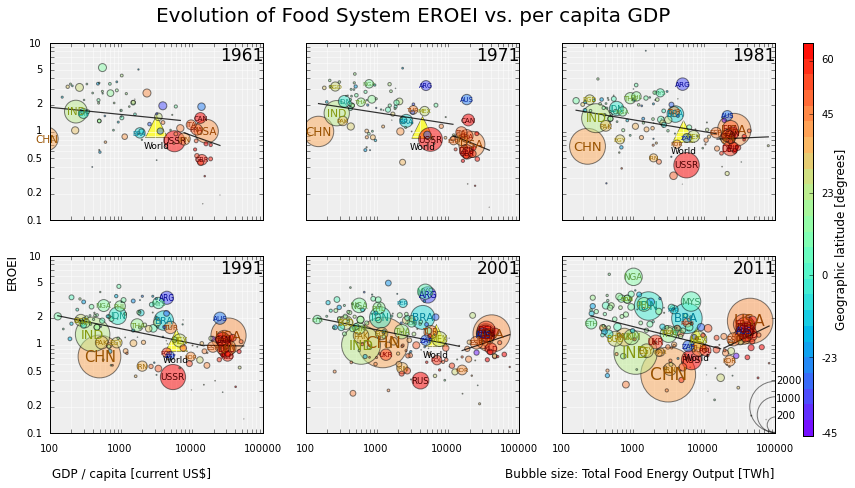

In [228]:
fig, ax = plt.subplots(2,3,subplot_kw=dict(axisbg='#EEEEEE',axisbelow=True),figsize=(13,7))

#init axes
for i in range(2):
    for j in range(3):
        ax[i,j].grid(color='white', linestyle='solid')
        ax[i,j].set_xlim([2,5])
        ax[i,j].set_ylim([-1,1])
        ax[i,j].xaxis.set_major_formatter(plt.NullFormatter())
        ax[i,j].yaxis.set_major_formatter(plt.NullFormatter())
        xlabels=[100,200,300,400,500,600,700,800,900,1000,2000,3000,4000,5000,6000,7000,8000,9000,10000,\
             20000,30000,40000,50000,60000,70000,80000,90000,100000]
        ax[i,j].set_xticks(np.log10(xlabels))
        ylabels=[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1,2,3,4,5,6,7,8,9,10]
        ax[i,j].set_yticks(np.log10(ylabels))
        #set manual labels [waiting for MPLD3 support]
        if i==1:
            ax[i,j].text(0,-0.1,100,horizontalalignment='center',transform=ax[i,j].transAxes)
            ax[i,j].text(0.33,-0.1,1000,horizontalalignment='center',transform=ax[i,j].transAxes)
            ax[i,j].text(0.66,-0.1,10000,horizontalalignment='center',transform=ax[i,j].transAxes)
            ax[i,j].text(1,-0.1,100000,horizontalalignment='center',transform=ax[i,j].transAxes)
        if j==0:
            ax[i,j].text(-0.04,0,0.1,horizontalalignment='right',verticalalignment='center',rotation=0,transform=ax[i,j].transAxes)
            ax[i,j].text(-0.04,0.16,0.2,horizontalalignment='right',verticalalignment='center',rotation=0,transform=ax[i,j].transAxes)
            ax[i,j].text(-0.04,0.35,0.5,horizontalalignment='right',verticalalignment='center',rotation=0,transform=ax[i,j].transAxes)
            ax[i,j].text(-0.04,0.51,1,horizontalalignment='right',verticalalignment='center',rotation=0,transform=ax[i,j].transAxes)
            ax[i,j].text(-0.04,0.66,2,horizontalalignment='right',verticalalignment='center',rotation=0,transform=ax[i,j].transAxes)
            ax[i,j].text(-0.04,0.85,5,horizontalalignment='right',verticalalignment='center',rotation=0,transform=ax[i,j].transAxes)
            ax[i,j].text(-0.04,1,10,horizontalalignment='right',verticalalignment='center',rotation=0,transform=ax[i,j].transAxes)
        
ax[1,0].text(0.01,-0.25,'GDP / capita [current US$]',size=12, horizontalalignment='left',transform=ax[1,0].transAxes)
ax[1,2].text(0.99,-0.25,'Bubble size: Total Food Energy Output [TWh]',size=12, horizontalalignment='right',transform=ax[1,2].transAxes)
ax[0,0].text(-0.2,-0.2,'EROEI',size=12, horizontalalignment='left',verticalalignment='top',rotation=90,transform=ax[0,0].transAxes)
    
ax[0,1].text(0.5,1.12,'Evolution of Food System EROEI vs. per capita GDP',size=20,\
             horizontalalignment='center',transform=ax[0,1].transAxes)

for k1 in range(2):
    for k2 in range(3):
        r=[[],[],[],[],[]]
        for i in eroei_bycountry.keys():
            if i not in {'World + (Total)','China, mainland'}:
                try:
                    x=np.log10(gdp.loc[country_name_converter(i),1961+10*(k1*3+k2)])
                    y=np.log10(eroei_bytime[1961+10*(k1*3+k2)][i])
                    s=wgt_bytime[1961+10*(k1*3+k2)][i]
                    if ~((np.isnan(x))|(np.isnan(y))):
                        r[0].append(x)
                        r[1].append(y)
                        r[2].append(s)
                        r[3].append(i)
                        r[4].append(country_lat[i])
                except: pass
        try:
            
            #world
            ax[k1,k2].plot(WLD[1961+10*(k1*3+k2)][0], WLD[1961+10*(k1*3+k2)][1],marker='^',\
                           lw=4,alpha=0.7,color="yellow",markersize=22,zorder=0)
            ax[k1,k2].text(WLD[1961+10*(k1*3+k2)][0],WLD[1961+10*(k1*3+k2)][1]-0.25,'World',horizontalalignment='center',size=9)
            
            #plot main data
            #sort r list first, based on bubblesizes to arrange them in the z-plane and make sure smaller bubbles are on top
            r=np.array(sorted(np.array(r,dtype='object').T.tolist(),\
                                      key=itemgetter(2),reverse=True),dtype='object').T.tolist()
    
            scatter=ax[k1,k2].scatter(r[0],r[1],np.array(r[2])*1.3,r[4],alpha=0.5,cmap = plt.cm.rainbow,vmin=-45,vmax=60)
            tooltip = mpld3.plugins.PointLabelTooltip(scatter, labels=[repr(i) for i in r[3]])
            mpld3.plugins.connect(fig, tooltip)
            
            #plot country labels
            for i, txt in enumerate(r[2]):
                if r[2][i]>50:
                    #coose color, make darker
                    col=np.array(cm.jet((r[4][i]+45)/105))*0.6
                    col[3]=1 #set alpha back to 1
                    try: 
                        ax[k1,k2].text(r[0][i],r[1][i],\
                            cc[country_name_converter4(r[3][i])][0],horizontalalignment='center',\
                            verticalalignment='center',size=2+r[2][i]**0.35,color=col)
                    except: 
                        #put on USSR when it exists
                        if r[3][i]=='USSR':
                            ax[k1,k2].text(r[0][i],r[1][i],\
                                'USSR',horizontalalignment='center',verticalalignment='center',size=9,color=col)
            
            #regression
            #sort r list after GDP
            r=np.array(sorted(np.array(r,dtype='object').T.tolist(),\
                                      key=itemgetter(0)),dtype='object').T.tolist()
            try:
                x1=r[0][0:int(len(r[0])*perc)]
                x0=[x1[0],x1[len(x1)-1]]
                y1=r[1][0:int(len(r[0])*perc)]
                g1=r[2][0:int(len(r[0])*perc)]
                #w = np.linalg.lstsq(np.array([ np.array(x1), np.ones(len(x1))]).T,y1)[0] # obtaining regression parameters
                #CAUTION, if using linalg.lstsq, w[0] becomes w[1] and vice-versa!
                w = np.polynomial.polynomial.polyfit(x1,y1,1,w=1+np.log10(g1))
                ax[k1,k2].plot(x0,w[1]*np.array(x0)+w[0],'k',linewidth=1.2,alpha=0.8)#,zorder=0)
            except: pass
            #second regression, top 20%
            try:
                x2=r[0][int(len(r[0])*perc):len(r[0])]
                x0=[x2[0],x2[len(x2)-1]]
                y2=r[1][int(len(r[0])*perc):len(r[0])]
                g2=r[2][int(len(r[0])*perc):len(r[0])]
                w = np.polynomial.polynomial.polyfit(x2,y2,1,w=1+np.log10(g2))
                #w = np.linalg.lstsq(np.array([ np.array(x2), np.ones(len(x2))]).T,y2)[0] # obtaining regression parameters
                #CAUTION, if using linalg.lstsq, w[0] becomes w[1] and vice-versa!
                ax[k1,k2].plot(x0,w[1]*np.array(x0)+w[0],'k',linewidth=1.2,alpha=0.8)#,zorder=0)
            except: pass
            ax[k1,k2].text(.9,.9,1961+10*(k1*3+k2),size=17,horizontalalignment='center',transform=ax[k1,k2].transAxes)    
            if [k1,k2]==[0,0]:
                ax2=fig.add_axes([0.93, 0.12, 0.01, 0.78])
                ax2.xaxis.set_major_formatter(plt.NullFormatter())
                ax2.yaxis.set_major_formatter(plt.NullFormatter())
                ax2.set_xticks([])
                x = range(2)
                y = np.array(range(2))*110
                z = [[z]*2 for z in range(2)]
                ax2.contourf(x,y,z,30,cmap = plt.cm.rainbow)
                ax2.set_yticks([0,22,45,68,90,105])
                ax2.set_ylim([0,110])
                ax2.yaxis.set_ticks_position('right')
                ax2.set_ylabel('Geographic latitude [degrees]',size=12,labelpad=-45)
                ax2.text(2,0,-45,horizontalalignment='left',transform=ax2.transAxes)
                ax2.text(2,0.19,-23,horizontalalignment='left',transform=ax2.transAxes)
                ax2.text(2,0.4,0,horizontalalignment='left',transform=ax2.transAxes)
                ax2.text(2,0.61,23,horizontalalignment='left',transform=ax2.transAxes)
                ax2.text(2,0.81,45,horizontalalignment='left',transform=ax2.transAxes)
                ax2.text(2,0.95,60,horizontalalignment='left',transform=ax2.transAxes)
        except:pass

#bubblesize
ax[1,2].scatter([5],[-0.905],[260],facecolors='none',alpha=0.5)
ax[1,2].scatter([5],[-0.79],[1300],facecolors='none',alpha=0.5)
ax[1,2].scatter([5],[-0.7],[2600],facecolors='none',alpha=0.5)
ax[1,2].text(1.01,0.1,'200',size=10, horizontalalignment='left',verticalalignment='center',transform=ax[1,2].transAxes)
ax[1,2].text(1.01,0.2,'1000',size=10, horizontalalignment='left',verticalalignment='center',transform=ax[1,2].transAxes)
ax[1,2].text(1.01,0.3,'2000',size=10, horizontalalignment='left',verticalalignment='center',transform=ax[1,2].transAxes)
fig.savefig(plotpath+'all_eroei.png',bbox_inches = 'tight', pad_inches = 0.1, dpi=150)
plt.show()

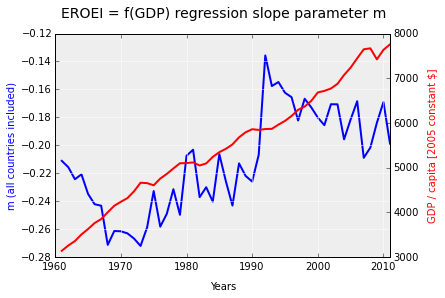

In [229]:
%matplotlib inline 
#disables mpld3, doesnt support dual axes currently

logmode=2 #loglog
animvalues() 

fig,ax = plt.subplots(1,subplot_kw=dict(axisbg='#EEEEEE'))
ax.grid(color='white', linestyle='solid')
ax2=ax.twinx();
#ax2.grid(color='white', linestyle='solid')

ax.plot(p.keys(),p.values(),linewidth=2,color='b')
ax2.plot(p.keys(),g,linewidth=2,color='r')
ax.set_title("EROEI = f(GDP) regression slope parameter m", y=1.05, size=14)
ax.set_xlabel('Years',labelpad=10)
ax.set_ylabel('m (all countries included)',color='b')
ax2.set_ylabel('GDP / capita [2005 constant $]',labelpad=10,color='r')
ax.set_xlim([1960,2011])
fig.savefig(plotpath+'gdp_eroei.png',bbox_inches = 'tight', pad_inches = 0.1, dpi=150)
plt.show()

yield

In [247]:
eroei_bycountry={}
eroei_bytime={}
missing_bycountry={}
quality_threshold=100

for i in set(list(countries) + ["World + (Total)"]):
    try:
        mis=json.loads(file(savepath+country_name_converter3(i)+'m.json','r').read())
        missing_bycountry[i]=len(mis['missing'])
    except: pass
for i in missing_bycountry.keys():
    if missing_bycountry[i]<quality_threshold:
        try:
            eroei_bycountry[i]=[[],[]]
            ero=json.loads(file(savepath+country_name_converter3(i)+'m.json','r').read())["eroei"][1]
            for j in sorted(ero.keys()):
                eroei_bycountry[i][0].append(int(j))
                eroei_bycountry[i][1].append(ero[j])
                if int(j) not in eroei_bytime: eroei_bytime[int(j)]={}
                eroei_bytime[int(j)].update({i:ero[j]})
        except: pass
        
wgt_bycountry={}
wgt_bytime={}
for i in missing_bycountry.keys():
    if missing_bycountry[i]<quality_threshold:
        wgt_bycountry[i]=[[],[]]
        for year in years:
            try:
                ero=json.loads(file(savepath+country_name_converter3(i)+repr(year)+'k2.json','r').read())
                val=sum([v['value'] for v in ero['links'] if v['source']==0])
                wgt_bycountry[i][0].append(year)
                wgt_bycountry[i][1].append(val)
                if year not in wgt_bytime: wgt_bytime[year]={}
                wgt_bytime[year].update({i:val})
            except: pass
            
sgt_bycountry={}
sgt_bytime={}
for i in missing_bycountry.keys():
    if missing_bycountry[i]<quality_threshold:
        sgt_bycountry[i]=[[],[]]
        for year in years:
            try:
                ero=json.loads(file(savepath+country_name_converter3(i)+repr(year)+'k3.json','r').read())
                val=sum([v['value'] for v in ero['links'] if v['source']==0])
                sgt_bycountry[i][0].append(year)
                sgt_bycountry[i][1].append(val)
                if year not in sgt_bytime: sgt_bytime[year]={}
                sgt_bytime[year].update({i:val})
            except: pass
for i in eroei_bytime:
    for j in eroei_bytime[i].keys():
        #if not in wgt, pop it from eroei too
        if ((j not in wgt_bytime[i]) or (j not in sgt_bytime[i])): eroei_bytime[i].pop(j)

In [262]:
from operator import itemgetter
p={}
g=[]
R={}
WLD={}

def animvalues():
    
    global p,g,R,WLD
    
    p={}
    g=[]
    R={}
    WLD={}
    for year in range(1961,2012):
        r=[[],[],[],[],[]]
        wld=[[],[]]
        for i in groei_bycountry.keys():
            if i not in {'China, mainland'}:
                try:
                    if logmode==2:
                        x=np.log10(sgt_bytime[year][i]/yld.xs([i,year], level=[0,1]).values[0][0])
                        y=np.log10(groei_bytime[year][i])
                    elif logmode==1:
                        x=np.log10(sgt_bytime[year][i]/yld.xs([i,year], level=[0,1]).values[0][0])
                        y=groei_bytime[year][i]
                    else:
                        x=sgt_bytime[year][i]/yld.xs([i,year], level=[0,1]).values[0][0]
                        y=groei_bytime[year][i]
                    s=wgt_bytime[year][i]
                    if ~((np.isnan(x))|(np.isnan(y))):
                        if i not in {'World + (Total)'}:
                            r[0].append(x)
                            r[1].append(y)
                            r[2].append(s)
                            r[3].append(i)
                            r[4].append(country_lat[i])
                        else:
                            wld[0]=x
                            wld[1]=y
                except:pass

        g.append(sgt_bytime[year]['World + (Total)']/yld.xs(['World + (Total)',year], level=[0,1]).values[0][0])
        try:
            x=r[0]
            y=r[1]
            w = np.linalg.lstsq(np.array([ np.array(x), np.ones(len(x))]).T,y)[0] # obtaining regression parameters
            p[year]=w[0]
            R[year]=r
            WLD[year]=[wld[0],np.average(r[1],weights=r[2])]
        except:pass

In [319]:
perc=0.8 #income perceantage - regression separator
    
def animate(frame):
    
    global ax,cax
    
    #init axes
    ax.cla()
    cax.cla()
    ax.tick_params(direction='out', pad=5)
    ax.grid(color='white', linestyle='solid')
    ax.set_title('Evolution of Agri-system EROEI vs. Yield',size=17)
    ax.title.set_y(1.03)
    ax.text(0.01,-0.12,'Yield [t/Ha]',size=13, horizontalalignment='left',transform=ax.transAxes)
    ax.text(0.99,-0.12,'Bubble size: Total Agriculture Energy Output [TWh]',size=13, horizontalalignment='right',transform=ax.transAxes)
    ax.text(-0.04,0.5,'EROEI',size=13, horizontalalignment='right',verticalalignment='center',rotation=90,transform=ax.transAxes)
    
    if logmode==2:
        ax.set_xlim(-2,2)
        ax.set_ylim(-1,2)
        xlabels=[0.01,0.02,0.03,0.04,0.05,0.06,0.07,0.08,0.09,\
            0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,\
             1,2,3,4,5,6,7,8,9,10,20,30,40,50,60,70,80,90,100]
        ax.set_xticks(np.log10(xlabels))
        ax.set_xticklabels([0.01,'','','','','','','','',0.1,'','','','','','','','',1,'','','','','','','','',10,'','','','','','','','',100])
        ylabels=[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1,2,3,4,5,6,7,8,9,10,20,30,40,50,60,70,80,90,100]
        ax.set_yticks(np.log10(ylabels))
        ax.set_yticklabels([0.1,'',0.3,'','','','','','',1,'',3,'','','','','','',10,'',30,'','','','','','',100])
    elif logmode==1:
        ax.set_xlim(-2,2)
        ax.set_ylim(0,15)
        xlabels=[0.01,0.02,0.03,0.04,0.05,0.06,0.07,0.08,0.09,\
            0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,\
             1,2,3,4,5,6,7,8,9,10,20,30,40,50,60,70,80,90,100]
        ax.set_xticks(np.log10(xlabels))
        ax.set_xticklabels([0.01,'','','','','','','','',0.1,'','','','','','','','',1,'','','','','','','','',10,'','','','','','','','',100])
    else:
        ax.set_xlim(0,8)
        ax.set_ylim(0,15)
    
    ax.xaxis.set_ticks_position('bottom')
    ax.yaxis.set_ticks_position('left')
    
    #world
    ax.plot(WLD[frame+years[0]][0], WLD[frame+years[0]][1],marker='^',lw=4,alpha=0.7,color="yellow",markersize=30,zorder=0)
    ax.text(WLD[frame+years[0]][0],WLD[frame+years[0]][1]-0.15,'World',horizontalalignment='center',size=13)
    
    #countries
    #sort R list first, based on bubblesizes to arrange them in the z-plane and make sure smaller bubbles are on top
    R[frame+years[0]]=np.array(sorted(np.array(R[frame+years[0]],dtype='object').T.tolist(),\
                                      key=itemgetter(2),reverse=True),dtype='object').T.tolist()
    x = R[frame+years[0]][0]
    y = R[frame+years[0]][1]
    sc=ax.scatter(x, y, np.array(R[frame+years[0]][2])*5,R[frame+years[0]][4],alpha=0.5,cmap = plt.cm.rainbow,vmin=-45,vmax=60)
    ax.text(0.98,0.9,frame+years[0],size=30,\
             horizontalalignment='right',transform=ax.transAxes)
    for i, txt in enumerate(R[frame+years[0]][2]):
        if R[frame+years[0]][2][i]>50:
            #coose color, make darker
            col=np.array(cm.jet((R[frame+years[0]][4][i]+45)/105))*0.6
            col[3]=1 #set alpha back to 1
            try: ax.text(R[frame+years[0]][0][i],R[frame+years[0]][1][i]-0.02,\
                    cc[country_name_converter4(R[frame+years[0]][3][i])][0],horizontalalignment='center',\
                    verticalalignment='center',size=7+R[frame+years[0]][2][i]**0.35,color=col)
            except: 
                #put on USSR when it exists
                if R[frame+years[0]][3][i]=='USSR':
                    ax.text(R[frame+years[0]][0][i],R[frame+years[0]][1][i]-0.02,\
                        'USSR',horizontalalignment='center',verticalalignment='center',size=7+R[frame+years[0]][2][i]**0.35,color=col)

    #bubblesize
    if logmode==0:
        b_dist=[0.75,1.6,2.25]
        b_y=8
        b_base=0
    elif logmode==1:
        b_dist=[0.75,1.6,2.25]
        b_y=2
        b_base=0
    else:
        b_dist=[0.145,0.315,0.45]
        b_y=2
        b_base=1
    ax.scatter([b_y],[b_dist[0]-b_base],[5*200],facecolors='none',alpha=0.5)
    ax.scatter([b_y],[b_dist[1]-b_base],[5*1000],facecolors='none',alpha=0.5)
    ax.scatter([b_y],[b_dist[2]-b_base],[5*2000],facecolors='none',alpha=0.5)
    ax.text(b_y,2.2*b_dist[0]-b_base,'200',size=10, horizontalalignment='right',verticalalignment='center')
    ax.text(b_y,2.2*b_dist[1]-b_base,'1000',size=10, horizontalalignment='right',verticalalignment='center')
    ax.text(b_y,2.2*b_dist[2]-b_base,'2000',size=10, horizontalalignment='right',verticalalignment='center')
    
    #colorbar
    cbar=fig.colorbar(sc, cax=cax,extend='max')
    cbar.set_label('Geographic latitude [degrees]',size=13)
    cbar.set_alpha(1)
    cbar.draw_all()
    
    #regression - weighted after food energy output
    #resort R list, based on GDP to facilitate regression plot
    R[frame+years[0]]=np.array(sorted(np.array(R[frame+years[0]],dtype='object').T.tolist(),\
                                      key=itemgetter(0)),dtype='object').T.tolist()
    x = R[frame+years[0]][0]
    y = R[frame+years[0]][1]
    g = R[frame+years[0]][2] #weights for y
    #first regression, bottom 80% - defined by perc
    #if logmode!=0: #regression does not make sense in pure linear scales plot
    if False:
        try:
            x1=x[0:int(len(x)*perc)]
            x0=[x1[0],x1[len(x1)-1]]
            y1=y[0:int(len(x)*perc)]
            g1=g[0:int(len(x)*perc)]
            #w = np.linalg.lstsq(np.array([ np.array(x1), np.ones(len(x1))]).T,y1)[0] # obtaining regression parameters
            #CAUTION, if using linalg.lstsq, w[0] becomes w[1] and vice-versa!
            w = np.polynomial.polynomial.polyfit(x1,y1,1,w=1+np.log10(g1))
            ax.plot(x0,w[1]*np.array(x0)+w[0],'k--',linewidth=2,alpha=0.8)#,zorder=0)
        except: pass
        #second regression, top 20%
        try:
            x2=x[int(len(x)*perc):len(x)]
            x0=[x2[0],x2[len(x2)-1]]
            y2=y[int(len(x)*perc):len(x)]
            g2=g[int(len(x)*perc):len(x)]
            w = np.polynomial.polynomial.polyfit(x2,y2,1,w=1+np.log10(g2))
            #w = np.linalg.lstsq(np.array([ np.array(x2), np.ones(len(x2))]).T,y2)[0] # obtaining regression parameters
            #CAUTION, if using linalg.lstsq, w[0] becomes w[1] and vice-versa!
            ax.plot(x0,w[1]*np.array(x0)+w[0],'k--',linewidth=2,alpha=0.8)#,zorder=0)
        except: pass
        try:
            x0=[x[0],x[len(x)-1]]
            w = np.polynomial.polynomial.polyfit(x,y,1,w=1+np.log10(g))
            #ax.plot(x0,w[1]*np.array(x0)+w[0],'k--',linewidth=2,alpha=0.8)#,zorder=0)
        except: pass
    fig.savefig(plotpath+repr(frame+years[0])+'_log'+repr(logmode)+'_groei.png',bbox_inches = 'tight', pad_inches = 0.1, dpi=150)

In [ ]:
logmode=0
animvalues() 

# JSAnimation import available at https://github.com/jakevdp/JSAnimation
from JSAnimation import IPython_display
from matplotlib import animation

# init axes
fig = plt.figure(figsize=(10,6))
ax = plt.axes(axisbg='#EEEEEE',axisbelow=True)
cax = fig.add_axes([0.93, 0.13, 0.013, 0.78]) 

animation.FuncAnimation(fig, animate, frames=2012-1961, interval=20, blit=True)

In [ ]:
logmode=1
animvalues() 

# JSAnimation import available at https://github.com/jakevdp/JSAnimation
from JSAnimation import IPython_display
from matplotlib import animation

# init axes
fig = plt.figure(figsize=(10,6))
ax = plt.axes(axisbg='#EEEEEE',axisbelow=True)
cax = fig.add_axes([0.93, 0.13, 0.013, 0.78]) 

animation.FuncAnimation(fig, animate, frames=2012-1961, interval=20, blit=True)

In [ ]:
logmode=2
animvalues() 

# JSAnimation import available at https://github.com/jakevdp/JSAnimation
from JSAnimation import IPython_display
from matplotlib import animation

# init axes
fig = plt.figure(figsize=(10,6))
ax = plt.axes(axisbg='#EEEEEE',axisbelow=True)
cax = fig.add_axes([0.93, 0.13, 0.013, 0.78]) 

animation.FuncAnimation(fig, animate, frames=2012-1961, interval=20, blit=True)

# Mapping yeah

In [ ]:
eroei_bycountry={}
eroei_bytime={}
missing_bycountry={}
quality_threshold=100
for i in set(list(countries) + ["World + (Total)"]):
    try:
        mis=json.loads(file(savepath+country_name_converter3(i)+'m.json','r').read())
        missing_bycountry[i]=len(mis['missing'])
    except: pass
for i in missing_bycountry.keys():
    if missing_bycountry[i]<quality_threshold:
        try:
            eroei_bycountry[i]=[[],[]]
            ero=json.loads(file(savepath+country_name_converter3(i)+'m.json','r').read())["eroei"][2] #choose which EROEI
            for j in sorted(ero.keys()):
                eroei_bycountry[i][0].append(int(j))
                eroei_bycountry[i][1].append(ero[j])
                if int(j) not in eroei_bytime: eroei_bytime[int(j)]={}
                eroei_bytime[int(j)].update({i:ero[j]})
        except: pass
wgt_bycountry={}
wgt_bytime={}
for i in missing_bycountry.keys():
    if missing_bycountry[i]<quality_threshold:
        wgt_bycountry[i]=[[],[]]
        for year in years:
            try:
                ero=json.loads(file(savepath+country_name_converter3(i)+repr(year)+'k3.json','r').read())
                val=sum([v['value'] for v in ero['links'] if v['source']==0])
                wgt_bycountry[i][0].append(year)
                wgt_bycountry[i][1].append(val)
                if year not in wgt_bytime: wgt_bytime[year]={}
                wgt_bytime[year].update({i:val})
            except: pass
for i in eroei_bytime:
    for j in eroei_bytime[i].keys():
        #if not in wgt, pop it from eroei too
        if j not in wgt_bytime[i]: eroei_bytime[i].pop(j)

In [ ]:
#load empty data.csv
foodmap=pd.read_csv(masterpath.replace('db','map')+'data_empty.csv')
#convert years from 1999.0 format to 1999 for csv, quite trciky with pandas
foodmap["YEAR"]=foodmap["YEAR"].fillna("").astype(str)
for i in foodmap.index:
    foodmap.loc[i,"YEAR"]=foodmap.loc[i,"YEAR"][0:4]

fill foodmap dataframe

In [ ]:
for c in eroei_bycountry.keys():
    try: 
        for i in range(len(eroei_bycountry[c][0])):
            foodmap.loc[(2011-int(eroei_bycountry[c][0][i]))*6+1,cc[country_name_converter4(c)][0]]=\
            eroei_bycountry[c][1][i]
            foodmap.loc[(2011-int(groei_bycountry[c][0][i]))*6+2,cc[country_name_converter4(c)][0]]=\
            groei_bycountry[c][1][i]
            foodmap.loc[(2011-int(wgt_bycountry[c][0][i]))*6+3,cc[country_name_converter4(c)][0]]=\
            wgt_bycountry[c][1][i]
            #foodmap.loc[(2011-int(wgt_bycountry[c][0][i]))*6+5,cc[country_name_converter4(c)][0]]=\
            #wgt_bytime[year][i]/yld.xs([i,year], level=[0,1]).values[0][0]
    except: pass
for i in gdp.index:
    try:
        for j in gdp.loc[i].iteritems():
            foodmap.loc[(2011-j[0])*6+4,cc[country_name_converter4(i)][0]]=j[1]
    except: pass

save files for statplanet

In [ ]:
foodmap.to_csv(masterpath.replace('db','map')+'data.csv',index=False)
try:
    import zlib
    compression = zipfile.ZIP_DEFLATED
except:
    compression = zipfile.ZIP_STORED
zf = zipfile.ZipFile(masterpath.replace('db','map')+'data.zip', mode='w')
zf.write(masterpath.replace('db','map')+'data.csv','data.csv',compress_type=compression)
zf.close()

<br><p>We would like to express our gratitude to all of the developers of the libraries used and especially to the affiliates of *FAOSTAT* for their great database and openly accesible data. The data manipulation algorithms and visualization techniques are open sourced and freely reproducible, forks are welcome on <a href="https://github.com/csaladenes/Food-Energy">GitHub</a>. The concept and methodology are subject to copyright of the authors.</p><br>
<p>&copy; 2020</p><br>
<p><a href="http://food.csaladen.es">http://food.csaladen.es</a></p>